# Hidden Markov Models
###soroush mahdi
###99131050

## import and plot functions

In [ ]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-white')

K_ = 2 
N_ = 5
C_ = 14

In [ ]:
#these 2 functions are for plotting

def plot_smoothing(gamma):
    plt.figure(figsize=(15,8))
    K,T = gamma.shape
    xx = np.linspace(0, T-1, T)
    plt.subplot(411)
    plt.title('Smoothing distribution of test data')
    plt.ylabel('p(x=1|Y)')
    plt.plot(xx, gamma[0])
    plt.subplot(412)
    plt.ylabel('p(x=2|Y)')
    plt.plot(xx, gamma[1])

    plt.xlabel('time')
    plt.show()

def plot_logL(logL_list , title):
    plt.figure(figsize=(15,8))
    plt.subplot(411)
    plt.title(title)
    plt.ylabel('avg log likelihood')
    plt.plot(logL_list)
    plt.xlabel('iteration')
    plt.show()

##forward backward algorithm

In [ ]:
def comp_transitions(samples_Xs, K=K_):
    '''computes transitions matrix
       M[i][j] = p(x_t=j|x_t-1=i)
       samples_Xs = a list which contain targets 
       for each sample as np arrays
       maps first class to zero , second to one and...'''
    
    M = np.zeros((K,K) , dtype=np.longdouble)
    
    for X in samples_Xs:
        for i in range(len(X) - 1):
            M[X[i]-1][X[i+1]-1]+=1
    
    return (M.T / M.sum(axis=1)).T

def comp_pi(samples_Xs, K=K_):
    '''computes initial probabilty matrix
       pi[i] = p(x_0=i)
       samples_Xs = a list which contain targets 
       for each sample as np arrays
       maps first class to zero , second to one and...'''
    pi = np.zeros((K,), dtype=np.longdouble)
    for X in samples_Xs:
        pi[X[0]-1] += 1
        
    return pi / pi.sum()

In [ ]:
def ind_feature_probs(all_samples, K=K_ ) :
    '''computes a matrix which:
       eps_matrices[f_j][i][k] = p(fj_t = i | x_t = k )
       all_samples is a pandas df which contains all train samples
       concated together 
       in fact this function computes emission probabilties 
       for each feature as if they are independent'''
    max_series = all_samples.max()
    eps_matrices = [np.zeros((int(i)+1,K), dtype=np.longdouble) for i in max_series[1:-1]]
    
    for k in range(K):
        all_with_target_k = all_samples.loc[all_samples['target']==k+1]
        num_target = len(all_with_target_k)
        
        for f in range(len(eps_matrices)):
            key = 'f' + str(f+1)
            value_counts = all_with_target_k[key].value_counts()
            
            for i in range(int(max_series[f+1])+1):
                if i in value_counts.keys():
                    eps_matrices[f][i][k] = value_counts[i]/num_target
                else:
                    eps_matrices[f][i][k] = 0.0
                    
    
    return eps_matrices



def emission(feature_probs, sample, K=K_ , test=False):
    ''' computes Emission matrix for sample which
        E[i][t] = p(y_t|x_t = i)
        feature_probs is the output of ind_feature_probs function
        sample is a pd datafame which is the sample that we want to
        compute emission matrix for
    '''
    T = len(sample)
    E = np.ones((K,T), dtype=np.longdouble)
    for t in range(T):
        if test:
            features = sample.iloc[t].tolist()[1:]
        else:
            features = sample.iloc[t].tolist()[1:-1]
        for j in range(K):
            for ind , f_value in enumerate(features):
                if not pd.isnull(f_value):
                    if int(f_value) < feature_probs[ind].shape[0]:
                        E[j][t]*=feature_probs[ind][int(f_value)][j]
                    
    return E

In [ ]:
def alpha_recursion(pi, M, E):
    '''computes alpha probabilities based on
       pi,M and E matrices
       return alpha probabiltis for each time step and
       log likelihood
       forward[k][t] = alpha_t(j)'''
    K,T = E.shape
    forward = np.zeros_like(E, dtype=np.longdouble)
    forward[:,0] = pi * E[:,0]

    for t in range(1,T):
        forward[:,t] = E[:,t] * (M.T @ forward[:,t-1])

    forward_prob = np.log(forward.sum(axis=0)[-1])
    return forward, forward_prob

def beta_recursion(pi, M, E):
    '''computes beta probabilities based on
       pi,M and E matrices
       return beta probabiltis for each time step and
       likelihood
       backward[k][t] = beta_t(j)'''
    K,T = E.shape
    backward = np.zeros_like(E, dtype=np.longdouble)
    backward[: , -1]= 1.0
    
    for t in range(T-2, -1, -1):
        backward[:,t] = M @ (backward[:,t+1] * E[:,t+1])
    
    backward_prob = pi @ (backward[:,0] * E[:,0])
    return backward, backward_prob

def smoothing(forward, backward):
    '''computes gamma probs based on alpha and beta probs'''
    gamma = np.multiply(forward, backward)
    return gamma / (gamma.sum(axis=0))



##Viterbi

In [ ]:
def Viterbi(pi, M, E):
    '''perform viterbi algorithm based on
       pi,M and E matrices
       returns probabilty for the best sequence of targets
       and best sequence of targets itself'''
    K,T = E.shape
    viterbi = np.zeros_like(E, dtype=np.longdouble)
    bt = np.zeros_like(E) #->bt[i][0] = 0
    
    viterbi[:,0] = pi * E[:,0]
    
    for t in range(1,T):
        tmp = viterbi[:,t-1] * M.T
        viterbi[:,t] = E[:,t] * tmp.max(axis = 1)
        bt[:,t] = tmp.argmax(axis = 1)
    
    bestpathprob = viterbi.max(axis=0)[-1]
    bestpathpointer = viterbi.argmax(axis=0)[-1]
 
    sequence_states = np.zeros(T, dtype=int)
    sequence_states[T - 1] = bestpathpointer

    for t in range(T - 2,-1,-1):
        sequence_states[t] = bt[sequence_states[t+1], t+1]
    return bestpathprob, sequence_states

##leave one out cross validation on forward-backward and viterbi algorithms
###LOOCV function expect data in this format:

###LOOCV function expect data in this format:
>data[folder]
>>Contextual_data.xlsx<br> 
>>samples[folder]
>>>sample_i.csv 

this function has 2 modes: smoothing and viterbi:
<br>
in smoothing mode it will perform LOOCV on forward-backward algorithm, and for each sample calculates and print classification accuracy and smoothing distribution plot. at the end it will print mean classification accuracy.
<br>
in viterbi mode it will perform LOOCV on viterbi algorithm, and for each sample calculates and print classification accuracy. at the end it will print mean classification accuracy.

In [ ]:
def LOOCV(mode):
    '''mode should be viterbi or smoothing'''
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    acc_sum = 0.0
    if mode in ['viterbi' , 'smoothing']:
        for test in sample_ids:
            #preparing data
            test_ids = [test]
            train_samples = dict()
            test_samples = dict()
            for i in sample_ids:
                if i not in test_ids:
                    train_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')
                else:
                    test_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')

            train_samples_Xs = [train_samples[key]['target'].to_numpy() for key in train_samples.keys()]
            test_samples_Xs = [test_samples[key]['target'].to_numpy() for key in test_samples.keys()]

            all_train_samples = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)
            all_test_samples = pd.concat([test_samples[key] for key in test_samples.keys()], ignore_index=True,axis=0)
            #computing pi and M based on train samples
            M = comp_transitions(train_samples_Xs)
            pi = comp_pi(train_samples_Xs)
            #computing E for test sample based on train samples
            feature_probs = ind_feature_probs(all_train_samples)
            test_E = emission(feature_probs,test_samples[str(test_ids[0])])
            #for stabelity
            if (test_E == 0).any():
                test_E = test_E + 0.000000001
            if mode == 'smoothing': # -> smoothing algorithm
                alpha , _ = alpha_recursion(pi, M, test_E)
                beta , _ = beta_recursion(pi, M, test_E)
                gamma = smoothing(alpha,beta)
                print(f'test smaple id: {test_ids[0]}')
                acc = ((gamma.argmax(axis = 0) + 1) == test_samples_Xs[0]).sum() / gamma.shape[1]
                print(f'acc = {acc}')
                acc_sum += acc
                plot_smoothing(gamma)
            else : # -> viterbi
                _ , seq_states = Viterbi(pi , M , test_E)
                print(f'test smaple id: {test_ids[0]}')
                acc = ((seq_states + 1) == test_samples_Xs[0]).sum() / len(test_samples_Xs[0])
                print(f'acc = {acc}')
                acc_sum += acc
        
        print(f'mean acc: {acc_sum / len(sample_ids)}')

test smaple id: 1
acc = 0.9113924050632911


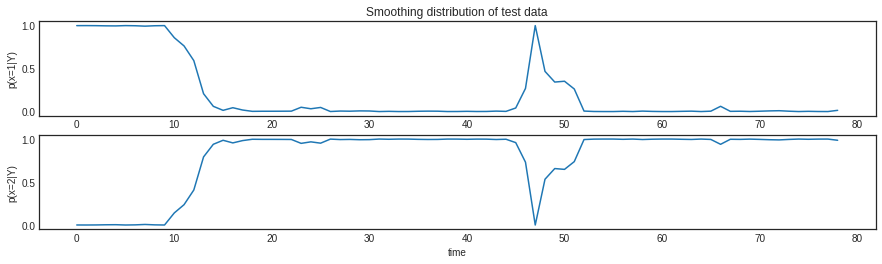

test smaple id: 2
acc = 0.8968253968253969


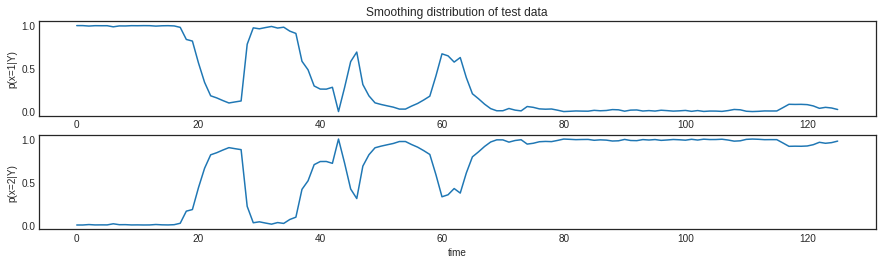

test smaple id: 3
acc = 0.8472222222222222


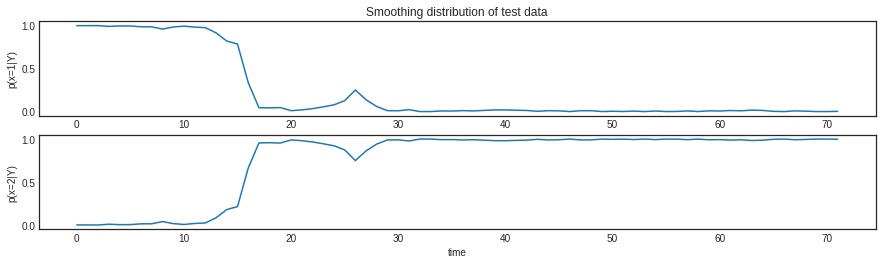

test smaple id: 4
acc = 0.8623853211009175


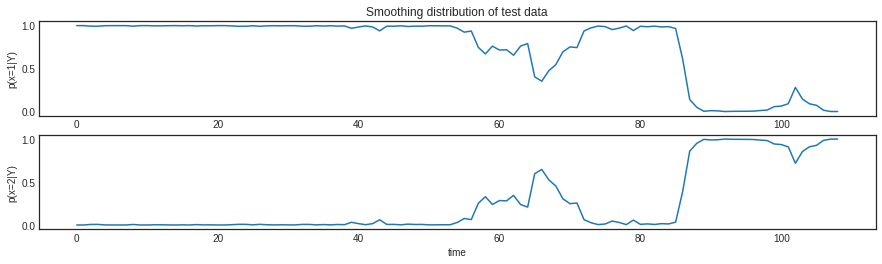

test smaple id: 5
acc = 0.9571428571428572


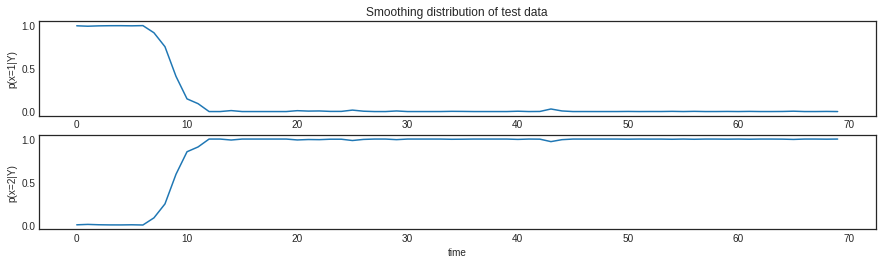

test smaple id: 6
acc = 0.9052631578947369


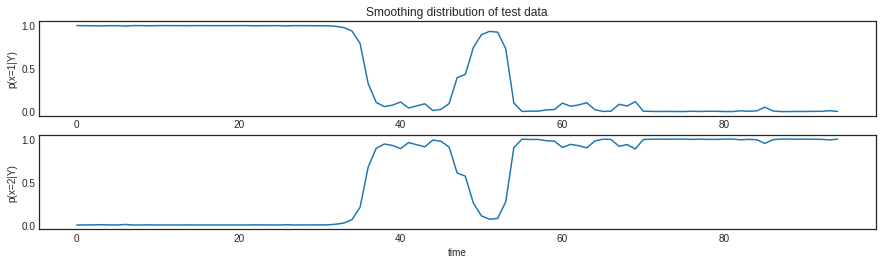

test smaple id: 7
acc = 0.963855421686747


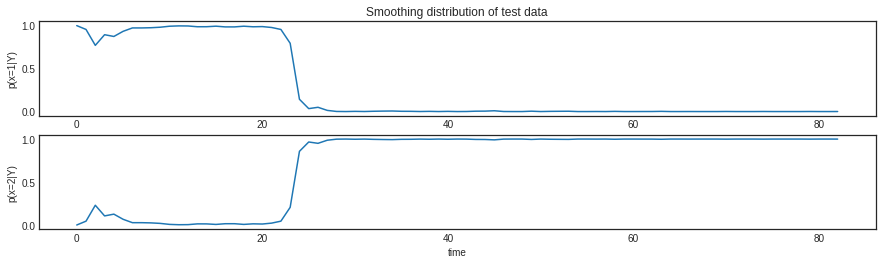

test smaple id: 8
acc = 1.0


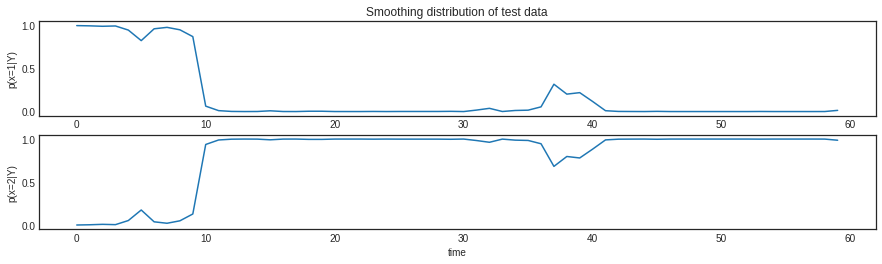

test smaple id: 11
acc = 0.8909090909090909


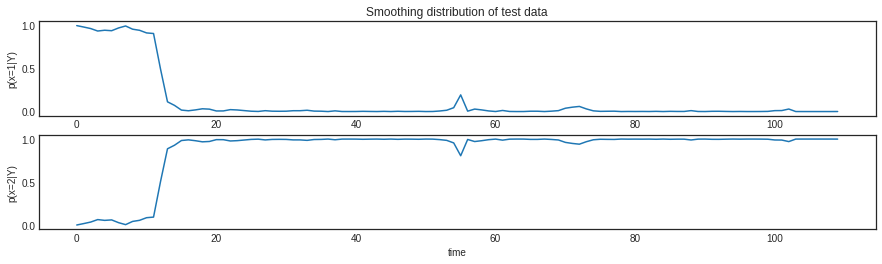

test smaple id: 12
acc = 0.9622641509433962


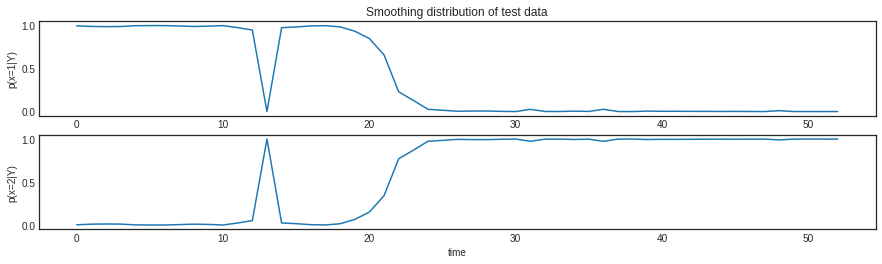

test smaple id: 13
acc = 0.9029126213592233


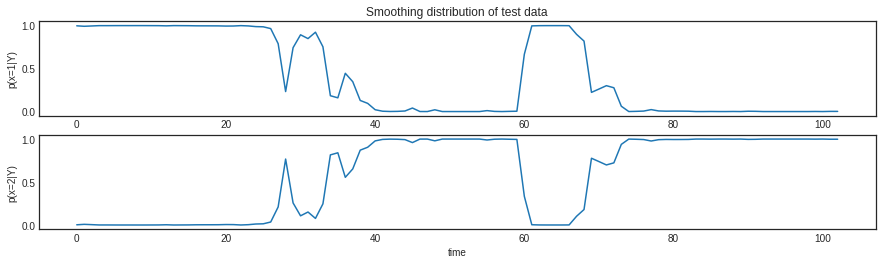

test smaple id: 14
acc = 0.9142857142857143


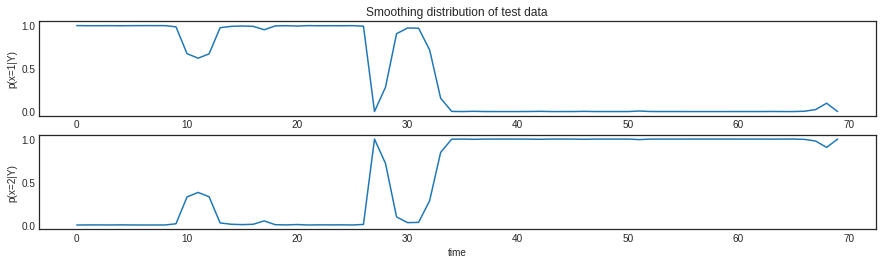

test smaple id: 15
acc = 0.9565217391304348


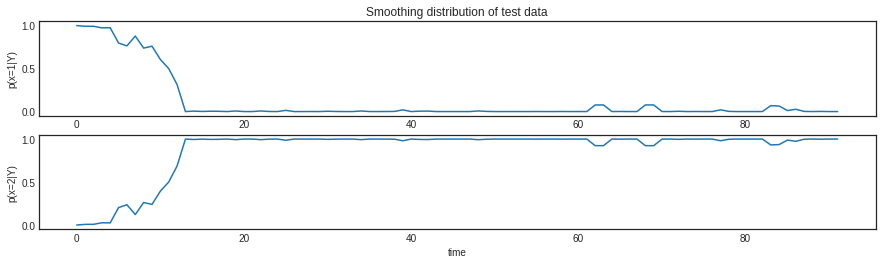

test smaple id: 16
acc = 0.3181818181818182


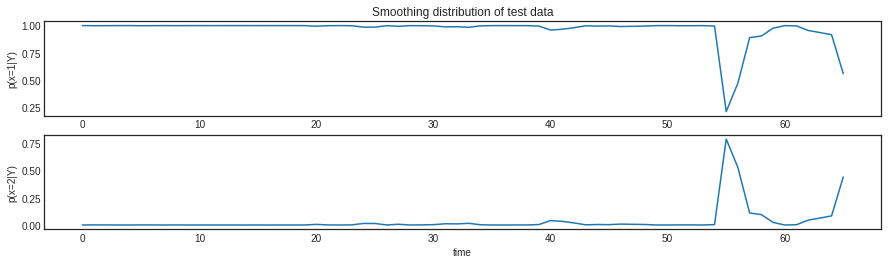

test smaple id: 18
acc = 0.6906474820143885


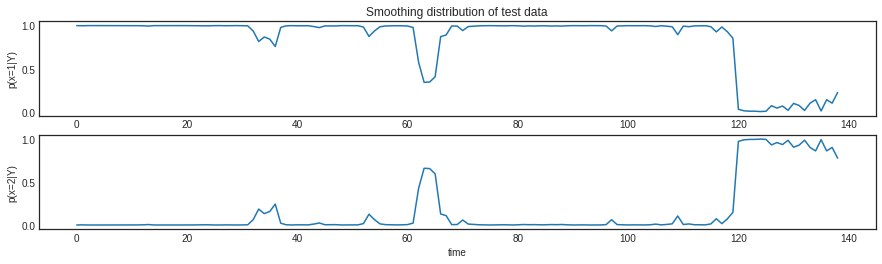

test smaple id: 19
acc = 0.9142857142857143


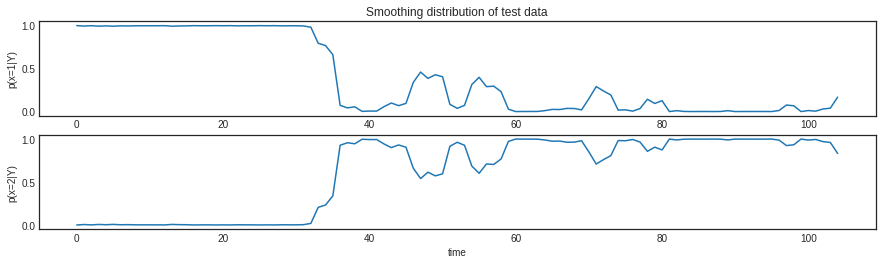

test smaple id: 20
acc = 0.9841269841269841


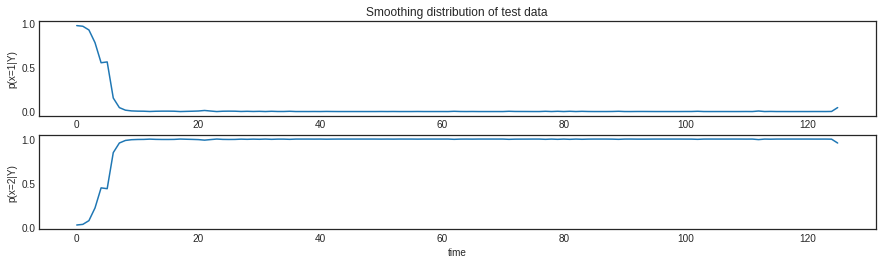

test smaple id: 21
acc = 0.3434343434343434


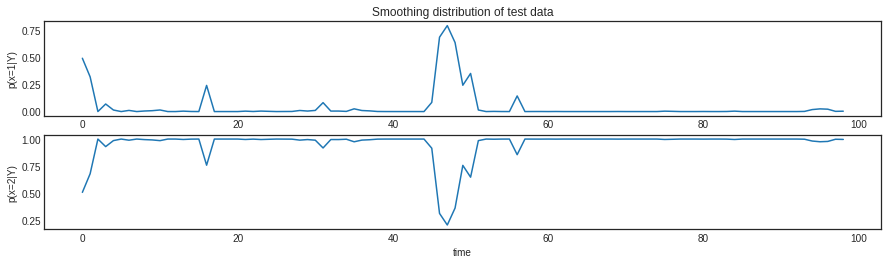

test smaple id: 23
acc = 0.5409836065573771


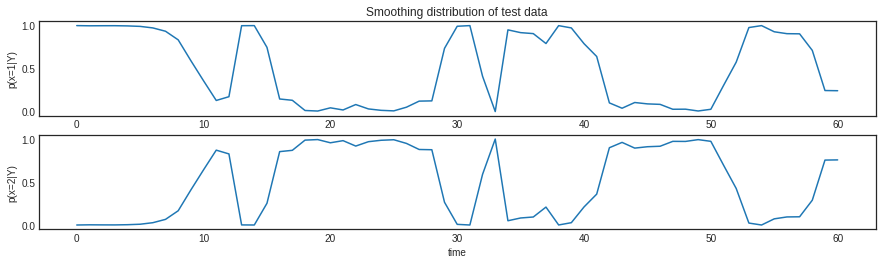

test smaple id: 24
acc = 0.8666666666666667


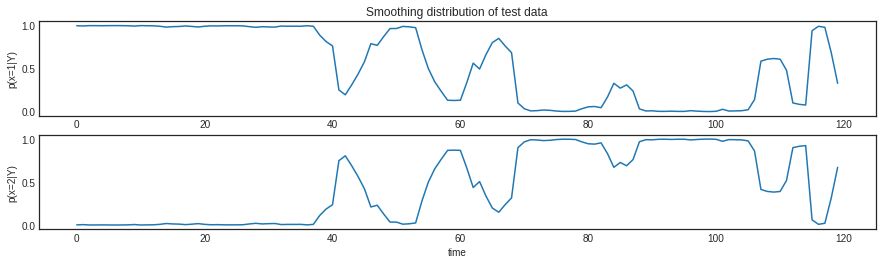

test smaple id: 25
acc = 0.8648648648648649


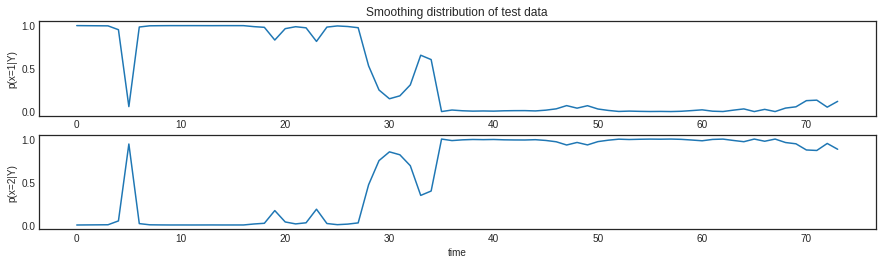

mean acc: 0.833055789461723


In [ ]:
LOOCV(mode = 'smoothing')

In [ ]:
LOOCV(mode = 'viterbi')

test smaple id: 1
acc = 0.9113924050632911
test smaple id: 2
acc = 0.9285714285714286
test smaple id: 3
acc = 0.8472222222222222
test smaple id: 4
acc = 0.8532110091743119
test smaple id: 5
acc = 0.9571428571428572
test smaple id: 6
acc = 0.9052631578947369
test smaple id: 7
acc = 0.963855421686747
test smaple id: 8
acc = 1.0
test smaple id: 11
acc = 0.8909090909090909
test smaple id: 12
acc = 0.9622641509433962
test smaple id: 13
acc = 0.9029126213592233
test smaple id: 14
acc = 0.9142857142857143
test smaple id: 15
acc = 0.9347826086956522
test smaple id: 16
acc = 0.3181818181818182
test smaple id: 18
acc = 0.6690647482014388
test smaple id: 19
acc = 0.9142857142857143
test smaple id: 20
acc = 0.9841269841269841
test smaple id: 21
acc = 0.3434343434343434
test smaple id: 23
acc = 0.5737704918032787
test smaple id: 24
acc = 0.7333333333333333
test smaple id: 25
acc = 0.8513513513513513
mean acc: 0.8266362606031873


##EM

In [ ]:
def pair_marginals(forward, backward, M, E):
    '''computes pair marginal probabilties based on
       alpha , beta , M and E'''
    K , T = forward.shape
    zeta = np.zeros((K,K,T-1), dtype=np.longdouble) #i,j,t
    for t in range(T-1):
        for j in range(K):
            for i in range(K):
                zeta[i][j][t] = (forward[i][t] * M[i,j] * E[j,t+1] * backward[j,t+1]) / ((forward[:,t] * backward[:,t]).sum())
    
    return zeta

In [ ]:
def MStepEmission(gammas, train_features, r):
    '''computes emission matrices for train samples in
    M step of EM algorithm 
    gammas is a list of gamma values for train samples
    train_features is a list of numpy arrays which each array contains features of
    one sample
    r is the index of train sample that we want to compute E for '''
    E = np.zeros_like(gammas[r] ,dtype=np.longdouble)
    K,Te = E.shape
    Ts = [len(f) for f in train_features]
    
    for te in range(Te):
        for i in range(len(train_features)):
            for t in range(Ts[i]):
                if (train_features[i][t]==train_features[r][te]).all():
                    E[:,te]+=gammas[i][:,t]
    return E / sum([gamma.sum(axis=1) for gamma in gammas]).reshape((K,1))


def MStepEmissionTest(gammas, train_features, test_features , T , K=K_):
    '''computes emission matrices for test samples in
    M step of EM algorithm 
    gammas is a list of gamma values for train samples
    train_features is a list of numpy arrays which each array contains features of
    one sample in train samples
    test_features is a list of numpy arrays which each array contains features of
    one sample in test samples 
    T is len test sample'''
    E = np.zeros((K,T) ,dtype=np.longdouble)
    Ts = [len(f) for f in train_features]
    
    for te in range(T):
        for i in range(len(train_features)):
            for t in range(Ts[i]):
                if (train_features[i][t]==test_features[te]).all():
                    E[:,te]+=gammas[i][:,t]
    return E / sum([gamma.sum(axis=1) for gamma in gammas]).reshape((K,1))


def EM(train_features, test_features, iter_num = 40 , K=K_):
    '''performs EM algorithm
       train_features is list that contains dataframes of only features for each
       train sample (so it does not have target and index columns)
       test_features is list that contains dataframes of only features for each
       test sample (so it does not have target and index columns)'''
    R = len(train_features)
    Rs = len(test_features)
    M = np.ones((K,K), dtype=np.longdouble) / K
    pi = np.arange(K , 0 , -1, dtype=np.longdouble).reshape((K,))
    pi = pi / pi.sum()
    Ts = [len(f) for f in train_features]
    test_Ts = [len(f) for f in test_features]
    Es = [np.ones((K,T), dtype=np.longdouble) / T for T in Ts]
    test_Es = [np.ones((K,T), dtype=np.longdouble) / T for T in test_Ts]
    train_features = [f.to_numpy() for f in train_features]
    test_features = [f.to_numpy() for f in test_features]
    train_avg_like = []
    test_avg_like = []
    for i in range(len(train_features)):
        train_features[i][np.isnan(train_features[i])] = -1.0
    for i in range(iter_num):

        gammas = []
        zetas = []
        lgls = []
        lgls_test = []
        for E in Es: #M step
            alpha, log_likelihood = alpha_recursion(pi,M,E)
            beta, _ = beta_recursion(pi,M,E)
            gamma = smoothing(alpha,beta)
            zeta = pair_marginals(alpha,beta,M,E)
            gammas.append(gamma)
            zetas.append(zeta)
            lgls.append(log_likelihood)
            
            
        train_avg_like.append((sum(lgls) / len(lgls)))
        #E step
        pi = sum([gamma[:,0] for gamma in gammas]) / R
        M = sum([zeta.sum(axis=2) for zeta in zetas]) / sum([gamma[:,:-1].sum(axis=1) for gamma in gammas])
        M = M.T
        for r in range(R):
            Es[r] = MStepEmission(gammas, train_features, r)
            
        for rs in range(Rs):
            test_Es[rs] = MStepEmissionTest(gammas, train_features, test_features[rs] , test_Ts[rs], K )
            if (test_Es[rs] == 0).any():
                test_Es[rs] = test_Es[rs] + 0.000000001

            alpha, log_likelihood = alpha_recursion(pi,M,test_Es[rs])
            lgls_test.append(log_likelihood)
            
        test_avg_like.append((sum(lgls_test) / len(lgls_test)))
            

            
    return pi,M,Es , test_Es , train_avg_like , test_avg_like
    
    

##leave one out cross validation on EM algorithm

###LOOCV_EM function expect data in this format:
>data[folder]
>>Contextual_data.xlsx<br> 
>>samples[folder]
>>>sample_i.csv 

this function perform LOOCV on EM algorithm, and for each sample calculates and print classification accuracy, smoothing distribution plot and log likelihood on train and test sets. at the end it will print mean classification accuracy.


In [ ]:
def LOOCV_EM():
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    acc_sum = 0.0
    for test in sample_ids:
        
        test_ids = [test]
        train_ids = [i for i in sample_ids if i not in test_ids]
        
        train_features = [pd.read_csv(f'data/samples/sample_{i}.csv').drop(['target', 'Unnamed: 0'], axis = 1)  for i in train_ids]
        test_features = [pd.read_csv(f'data/samples/sample_{i}.csv').drop(['target', 'Unnamed: 0'], axis = 1)  for i in test_ids]
        test_samples_Xs = [pd.read_csv(f'data/samples/sample_{i}.csv')['target'].to_numpy() for i in test_ids]
        
        print(f'test smaple id: {test_ids[0]}')
        pi,M,Es , test_Es , train_avg_like , test_avg_like = EM(train_features , test_features)
        test_E = test_Es[0]
        if (test_E == 0).any():
            test_E = test_E + 0.000000001
        alpha , _ = alpha_recursion(pi, M, test_E)
        beta , _ = beta_recursion(pi, M, test_E)
        gamma = smoothing(alpha,beta)
        acc = ((gamma.argmax(axis = 0) + 1) == test_samples_Xs[0]).sum() / gamma.shape[1]
        print(f'acc = {acc}')
        plot_smoothing(gamma)
        plot_logL(train_avg_like[1:] , 'train')
        plot_logL(test_avg_like , 'test')
        acc_sum+= acc
        
    print(f'mean acc: {acc_sum / len(sample_ids)}')

test smaple id: 1
acc = 0.8227848101265823


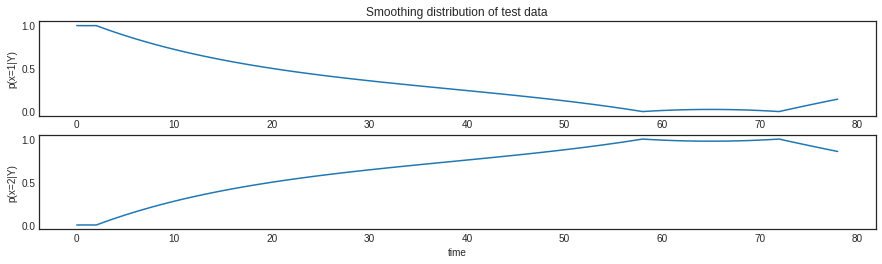

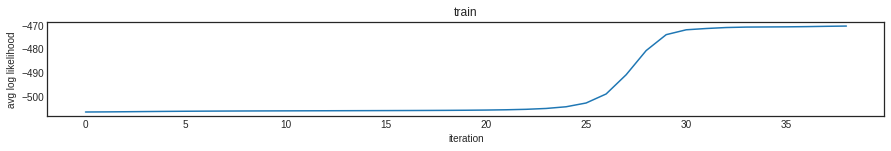

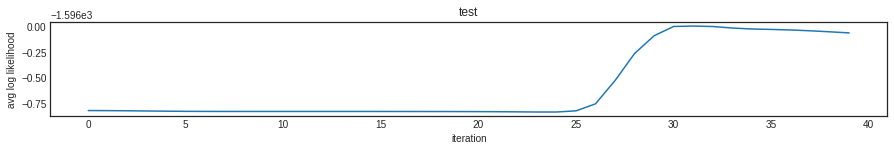

test smaple id: 2
acc = 0.8333333333333334


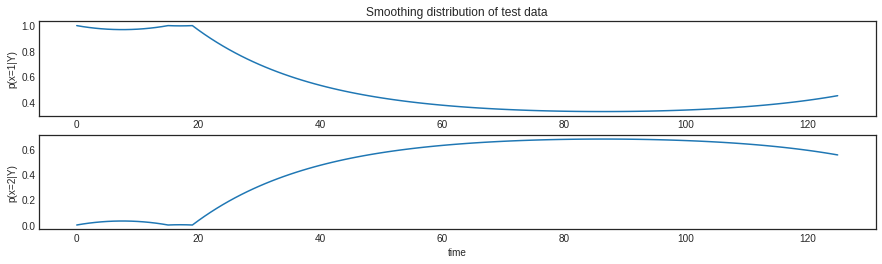

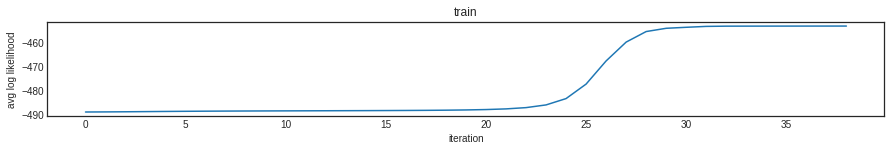

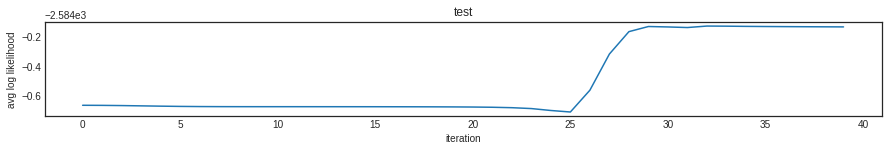

test smaple id: 3
acc = 0.8888888888888888


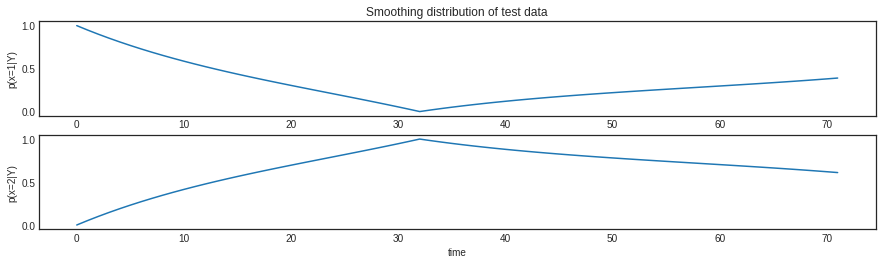

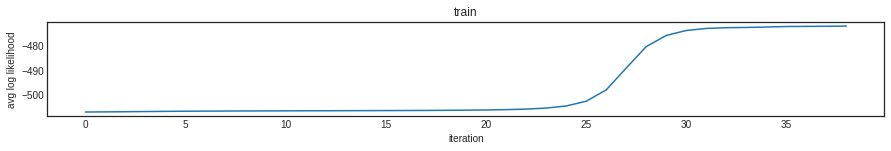

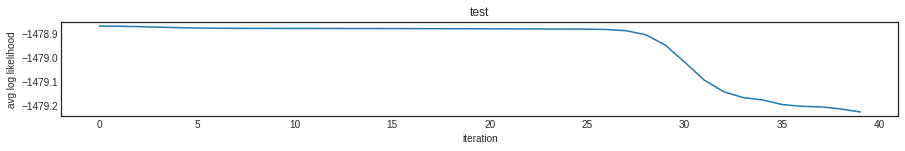

test smaple id: 4
acc = 0.7522935779816514


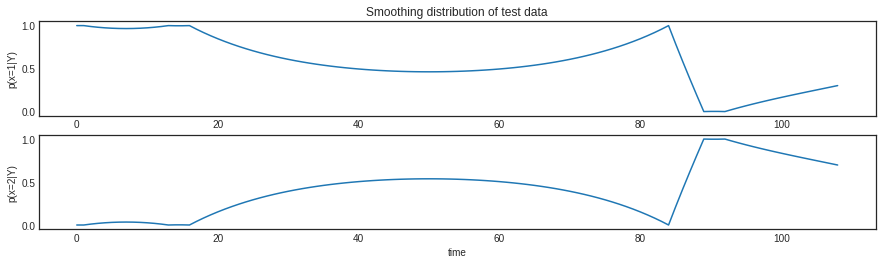

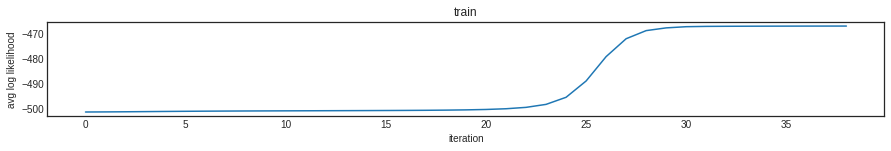

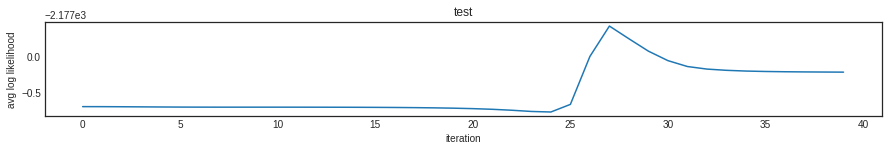

test smaple id: 5
acc = 0.8428571428571429


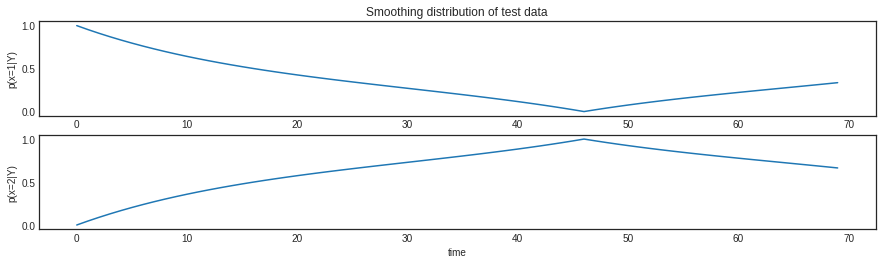

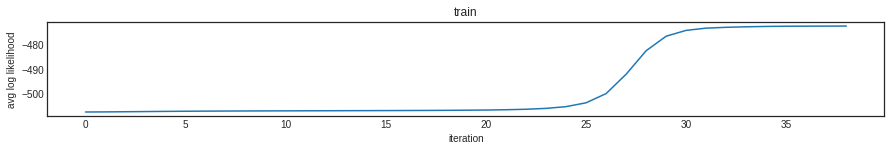

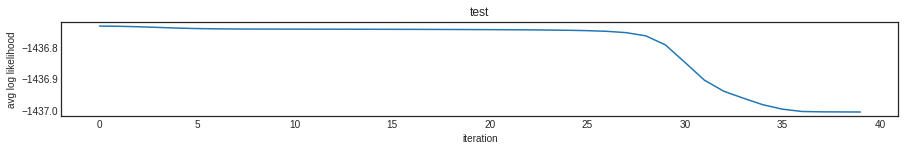

test smaple id: 6
acc = 0.9052631578947369


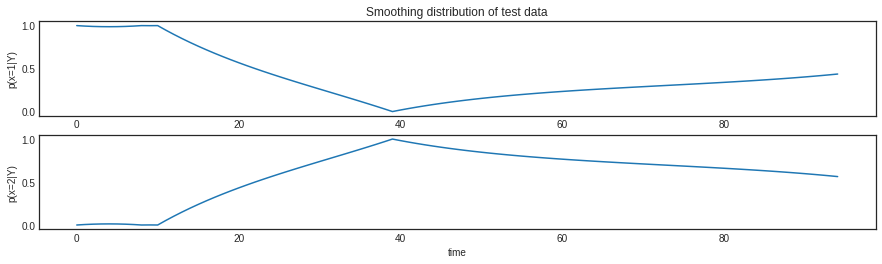

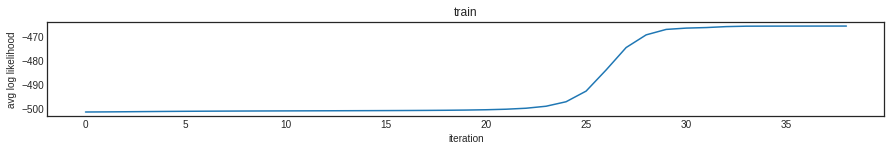

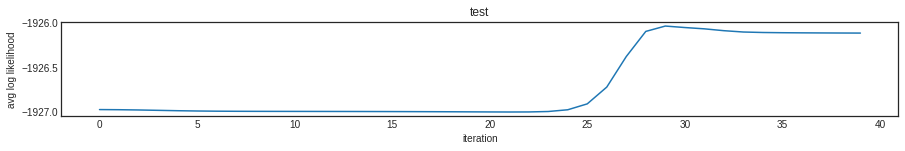

test smaple id: 7
acc = 0.8192771084337349


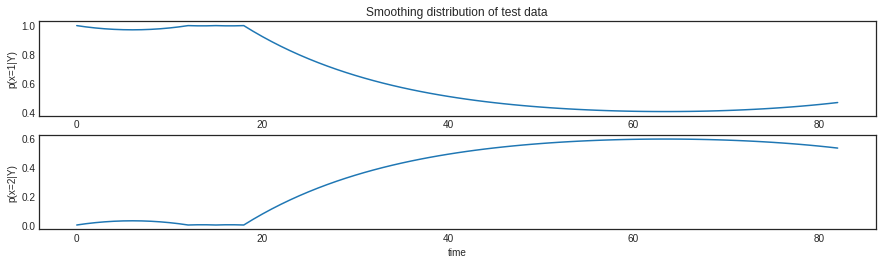

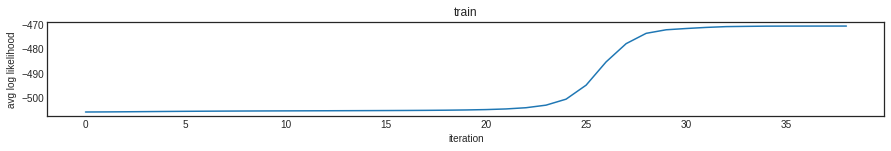

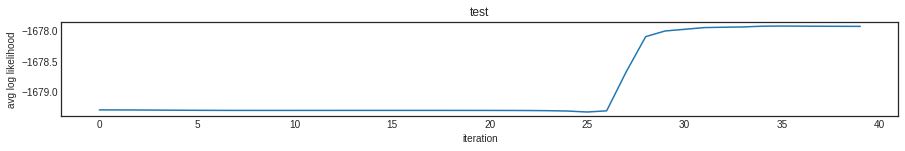

test smaple id: 8
acc = 0.9833333333333333


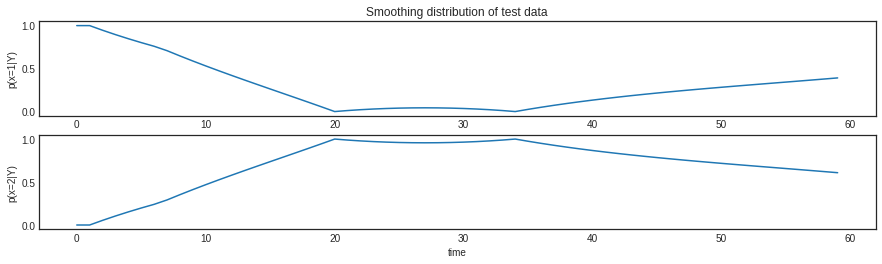

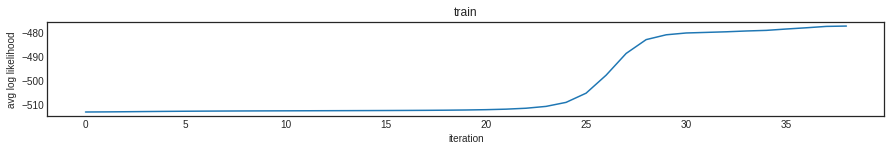

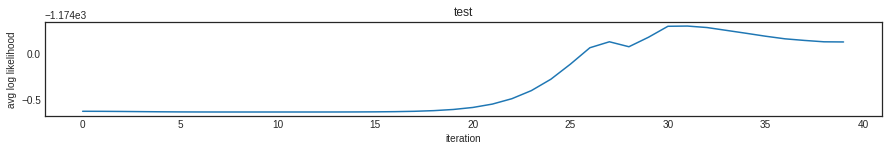

test smaple id: 11
acc = 0.8818181818181818


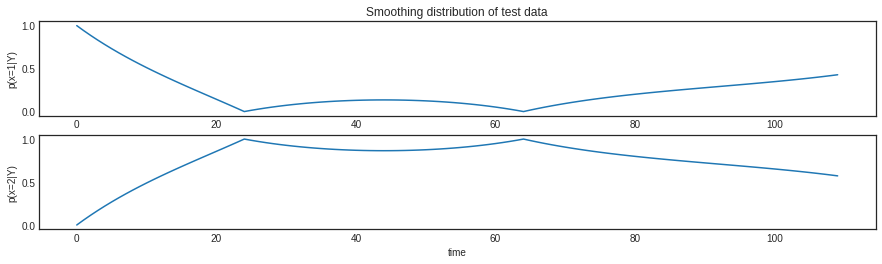

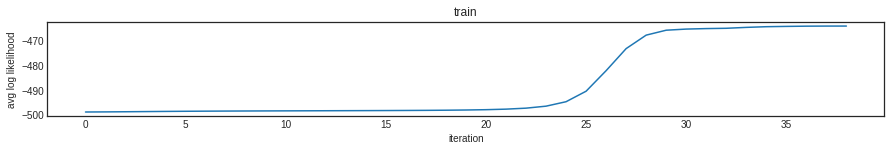

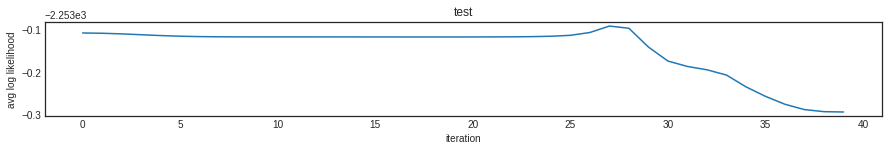

test smaple id: 12
acc = 0.3584905660377358


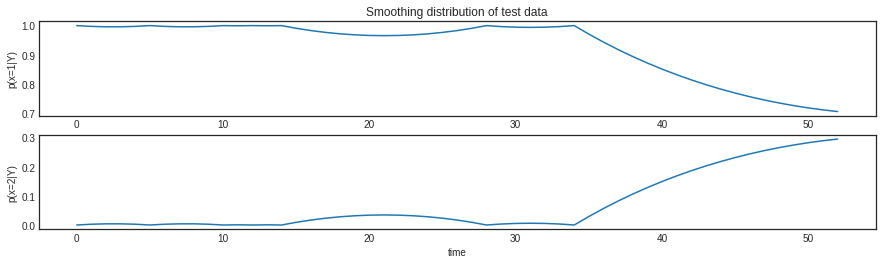

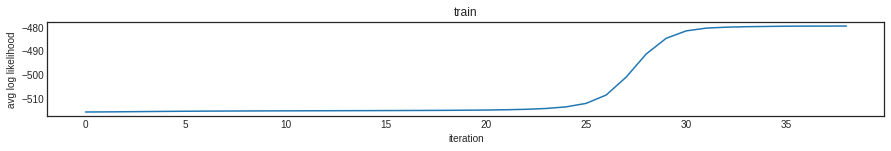

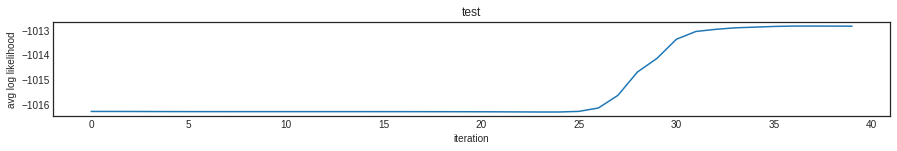

test smaple id: 13
acc = 0.883495145631068


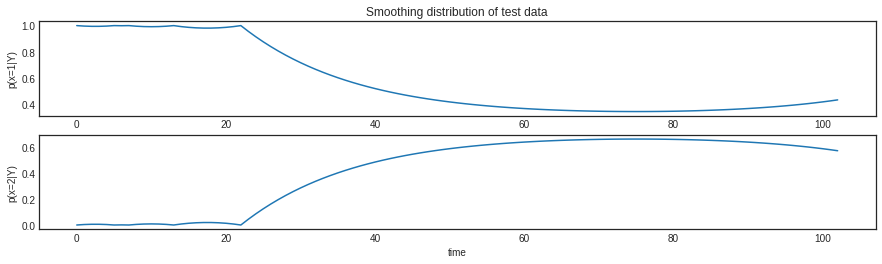

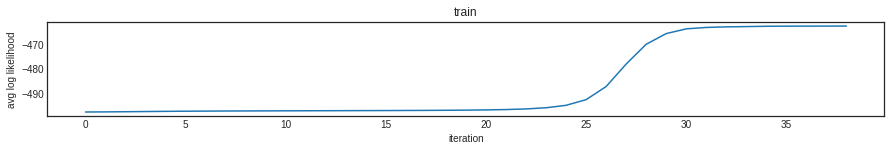

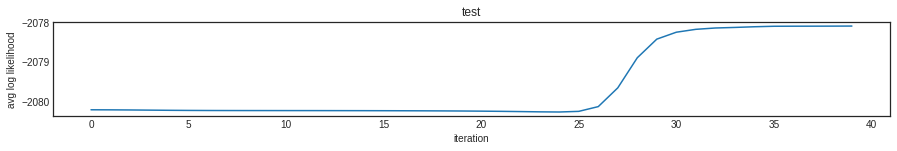

test smaple id: 14
acc = 0.7857142857142857


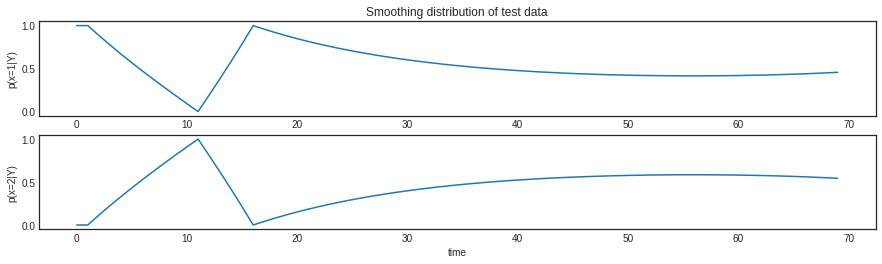

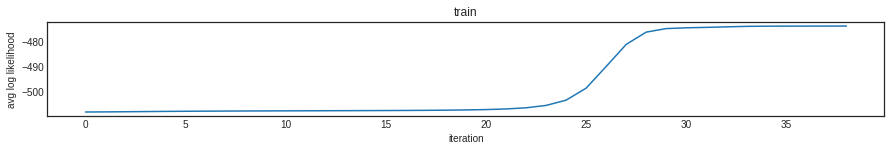

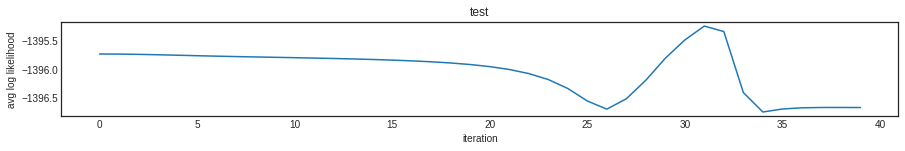

test smaple id: 15
acc = 0.9021739130434783


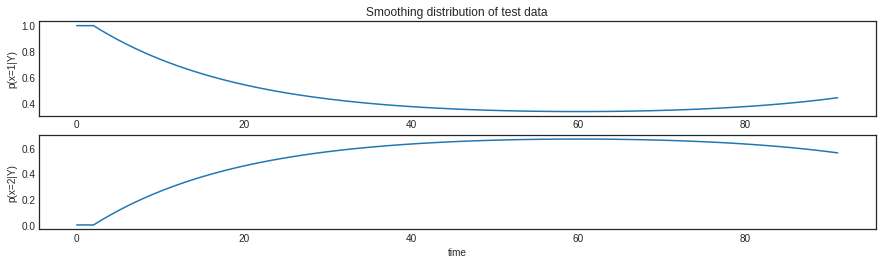

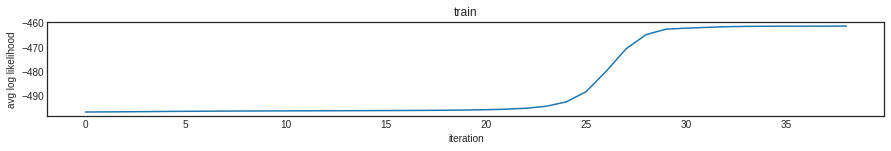

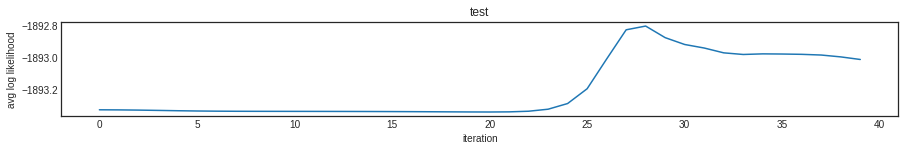

test smaple id: 16
acc = 0.2878787878787879


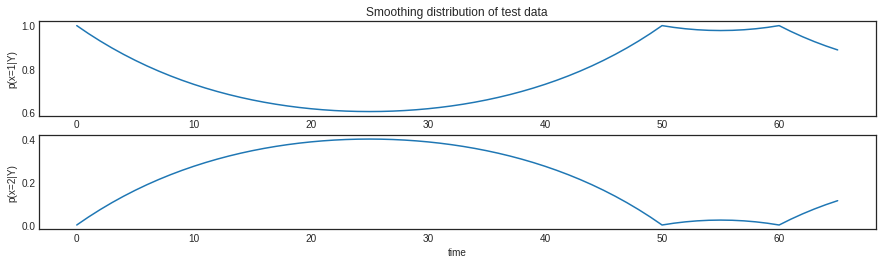

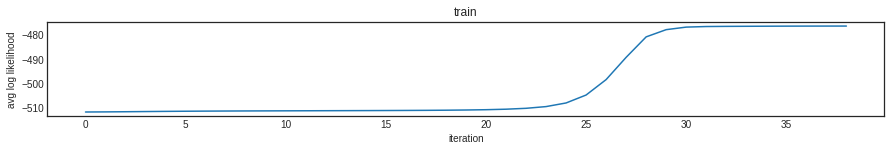

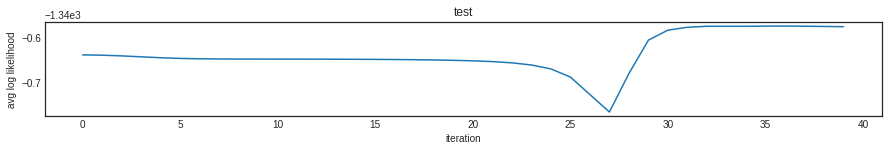

test smaple id: 18
acc = 0.6187050359712231


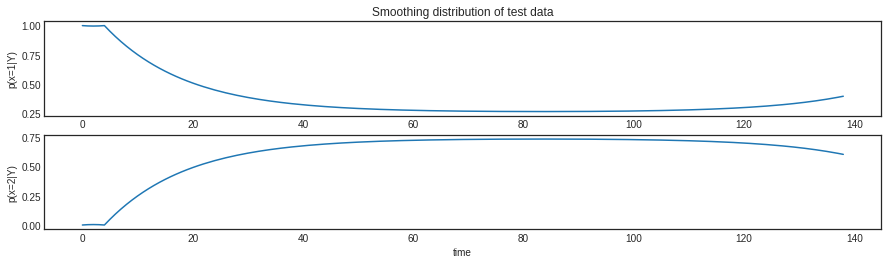

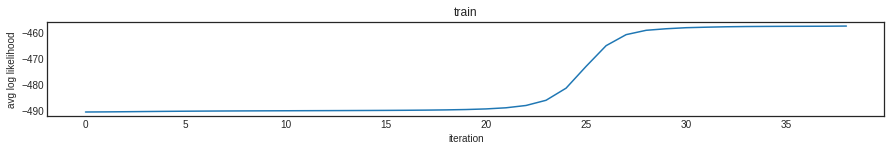

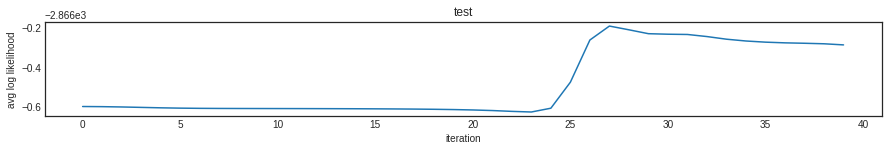

test smaple id: 19
acc = 0.8952380952380953


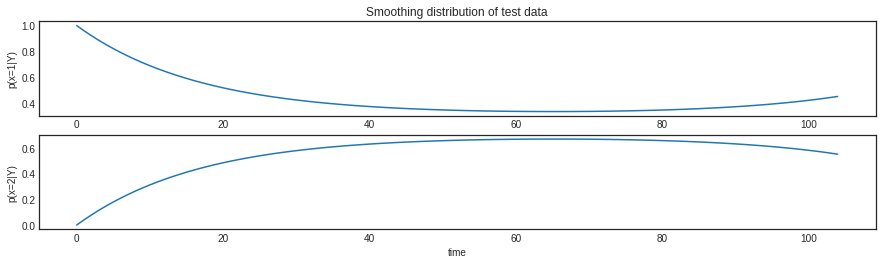

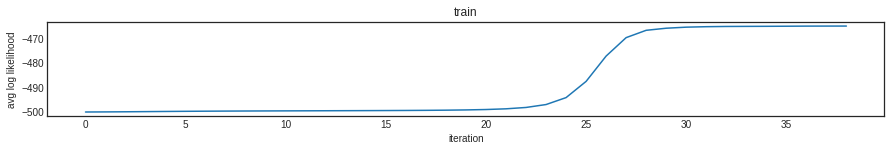

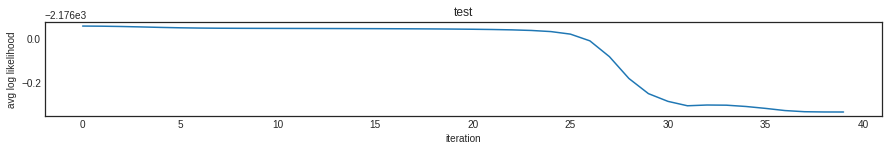

test smaple id: 20
acc = 0.8650793650793651


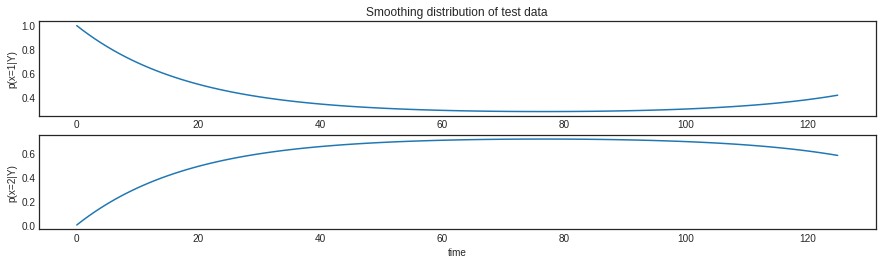

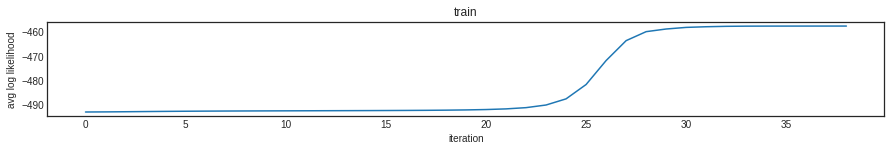

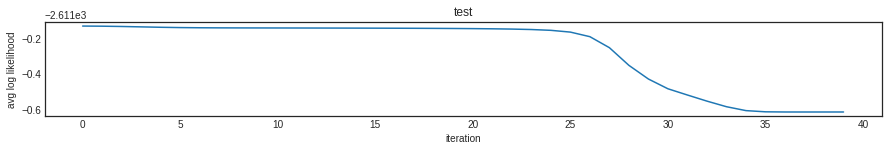

test smaple id: 21
acc = 0.42424242424242425


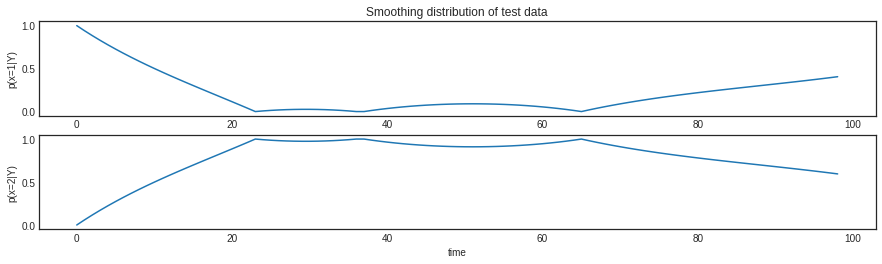

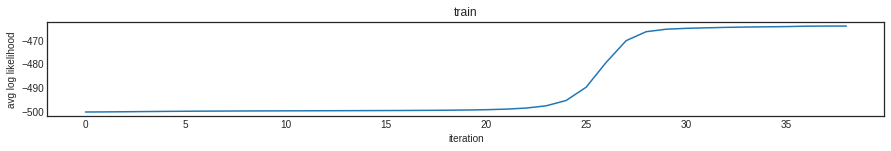

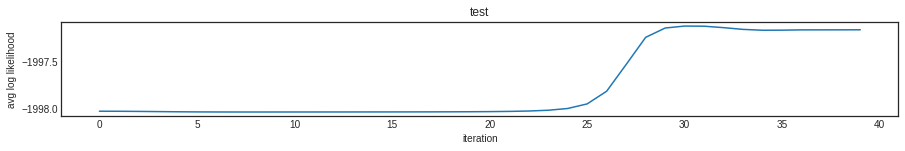

test smaple id: 23
acc = 0.3770491803278688


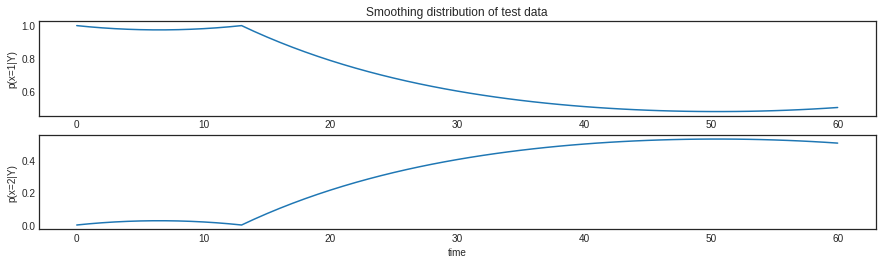

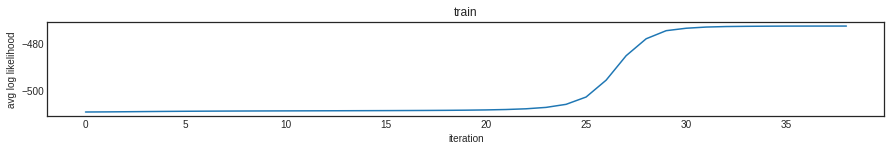

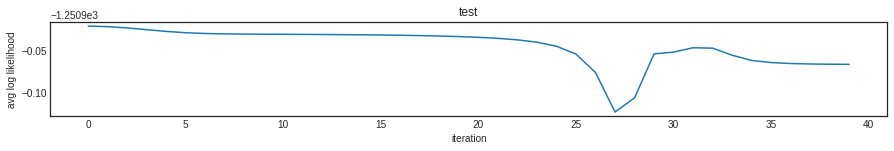

test smaple id: 24
acc = 0.5083333333333333


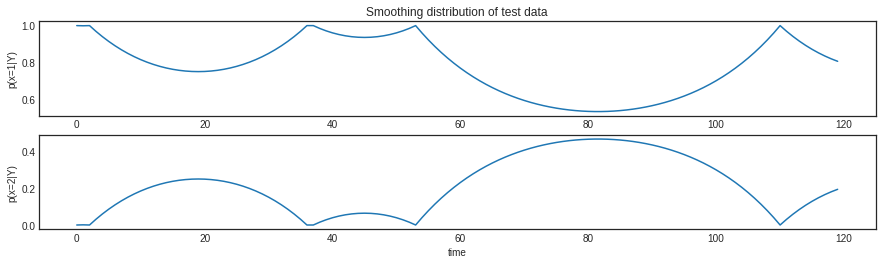

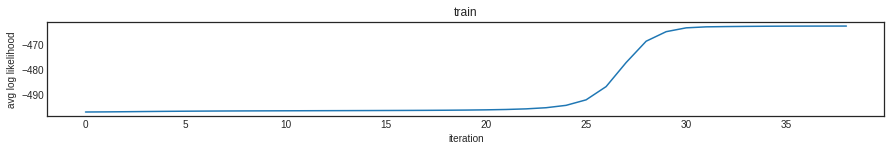

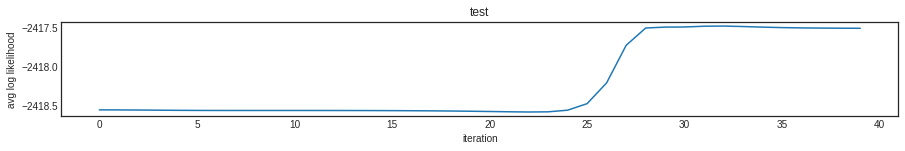

test smaple id: 25
acc = 0.8378378378378378


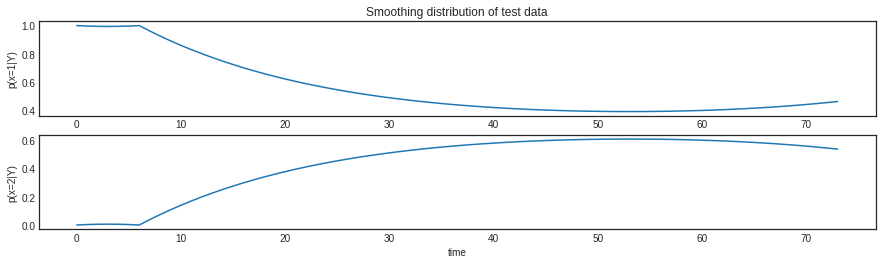

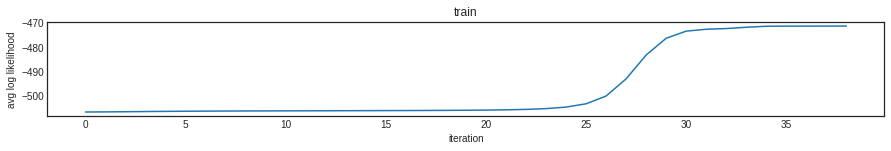

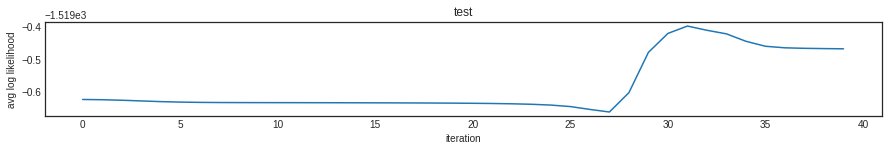

mean acc: 0.736861309762052


In [ ]:
LOOCV_EM()

##LOOCV on forward-backward algorithm without feature 5

In [ ]:
def LOOCV_withoutF5():
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    acc_sum = 0.0
    for test in sample_ids:
        #preparing data
        test_ids = [test]
        train_samples = dict()
        test_samples = dict()
        for i in sample_ids:
            if i not in test_ids:
                train_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv').drop(['f5'], axis = 1)
                train_samples[str(i)].fillna(0, inplace=True)
            else:
                test_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv').drop(['f5'], axis = 1)
                test_samples[str(i)].fillna(0, inplace=True)
                
        train_samples_Xs = [train_samples[key]['target'].to_numpy() for key in train_samples.keys()]
        test_samples_Xs = [test_samples[key]['target'].to_numpy() for key in test_samples.keys()]

        all_train_samples = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)
        all_test_samples = pd.concat([test_samples[key] for key in test_samples.keys()], ignore_index=True,axis=0)

        M = comp_transitions(train_samples_Xs)
        pi = comp_pi(train_samples_Xs)
        feature_probs = ind_feature_probs(all_train_samples)
        test_E = emission(feature_probs,test_samples[str(test_ids[0])])
        if (test_E == 0).any():
            test_E = test_E + 0.000000001

        alpha , _ = alpha_recursion(pi, M, test_E)
        beta , _ = beta_recursion(pi, M, test_E)
        gamma = smoothing(alpha,beta)
        print(f'test smaple id: {test_ids[0]}')
        acc = ((gamma.argmax(axis = 0) + 1) == test_samples_Xs[0]).sum() / gamma.shape[1]
        print(f'acc = {acc}')
        acc_sum += acc
        plot_smoothing(gamma)

        
    print(f'mean acc: {acc_sum / len(sample_ids)}')

test smaple id: 1
acc = 0.9367088607594937


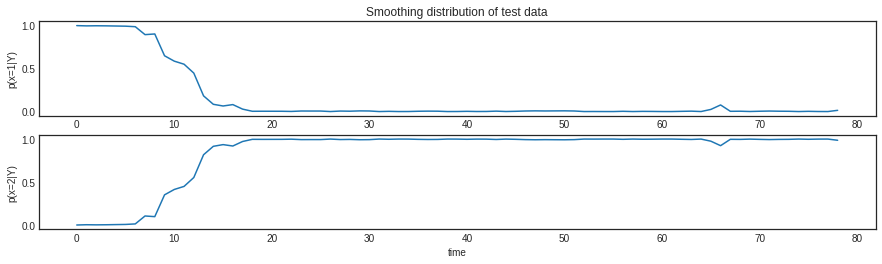

test smaple id: 2
acc = 0.8968253968253969


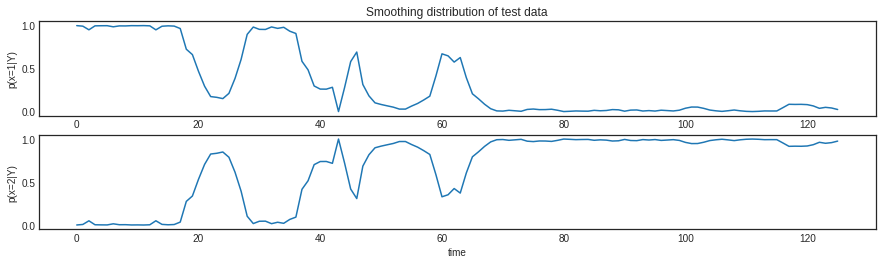

test smaple id: 3
acc = 0.8472222222222222


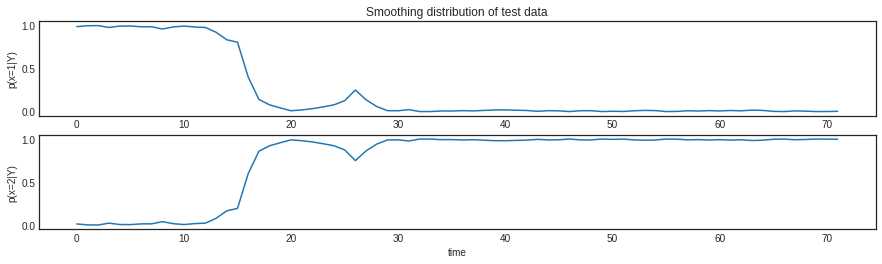

test smaple id: 4
acc = 0.8990825688073395


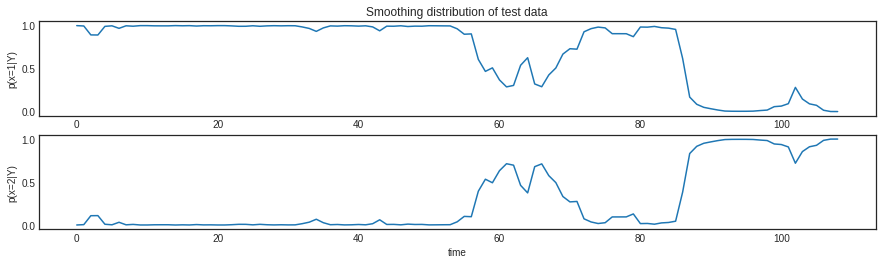

test smaple id: 5
acc = 0.9857142857142858


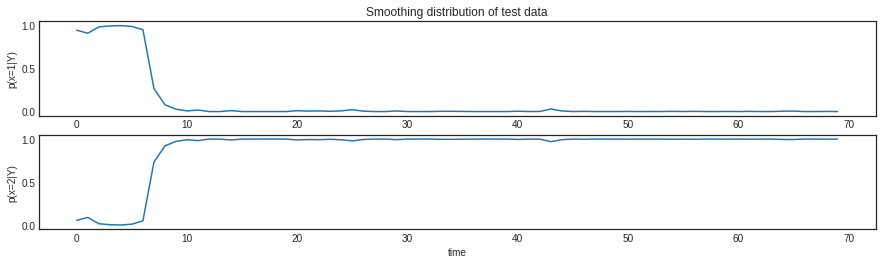

test smaple id: 6
acc = 0.9157894736842105


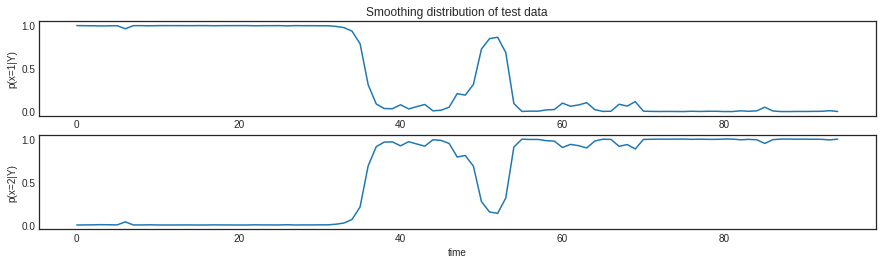

test smaple id: 7
acc = 0.963855421686747


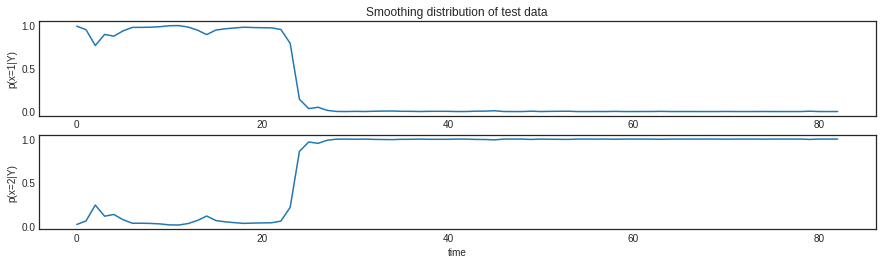

test smaple id: 8
acc = 1.0


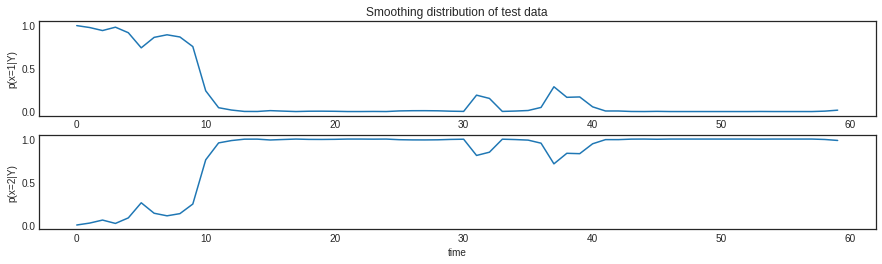

test smaple id: 11
acc = 0.8363636363636363


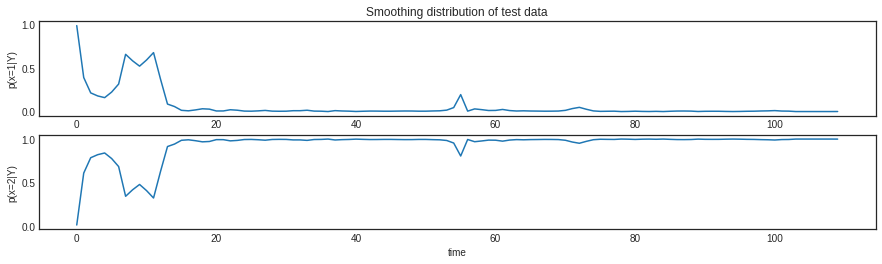

test smaple id: 12
acc = 1.0


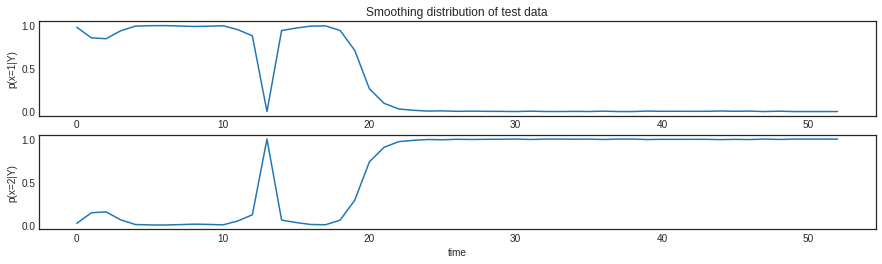

test smaple id: 13
acc = 0.8932038834951457


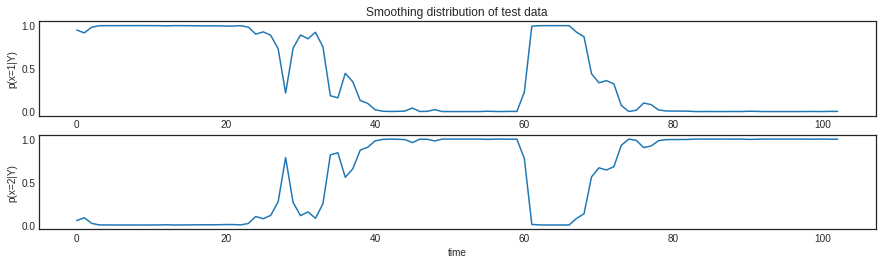

test smaple id: 14
acc = 0.9428571428571428


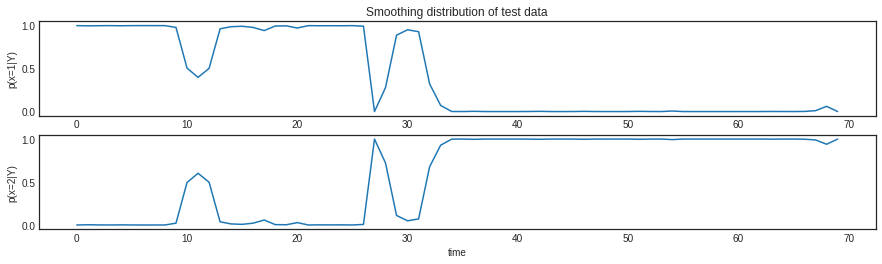

test smaple id: 15
acc = 0.8804347826086957


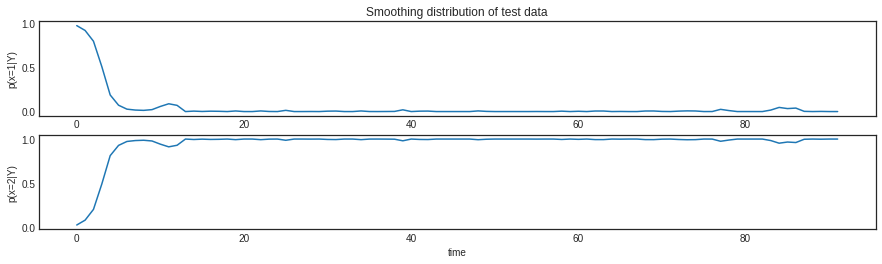

test smaple id: 16
acc = 0.3333333333333333


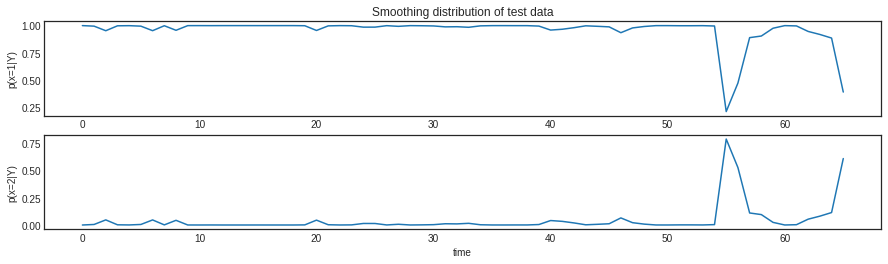

test smaple id: 18
acc = 0.7194244604316546


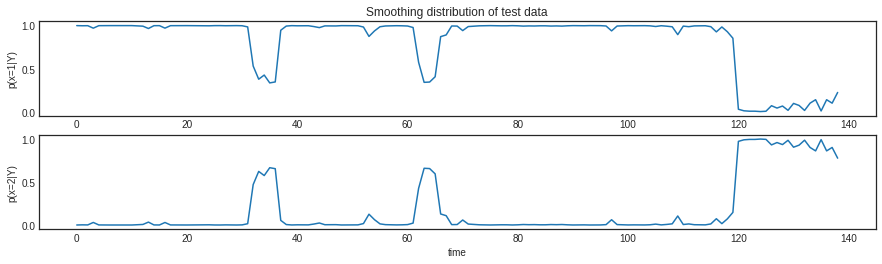

test smaple id: 19
acc = 0.9333333333333333


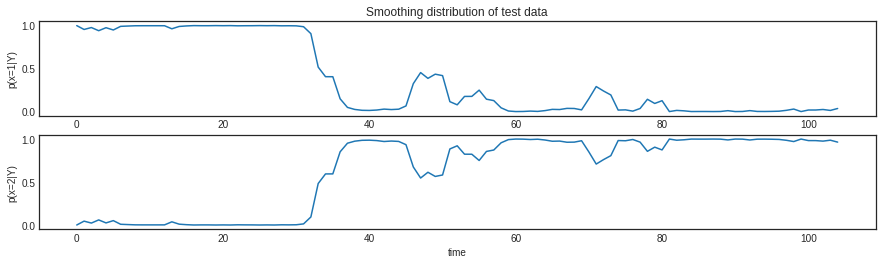

test smaple id: 20
acc = 0.9841269841269841


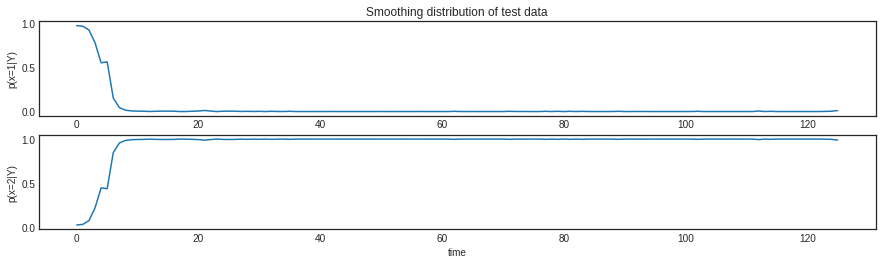

test smaple id: 21
acc = 0.3434343434343434


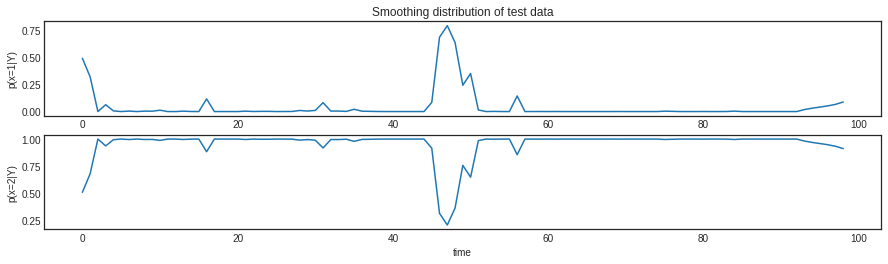

test smaple id: 23
acc = 0.2459016393442623


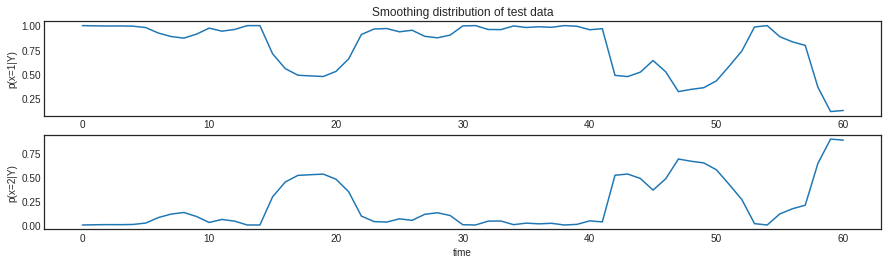

test smaple id: 24
acc = 0.825


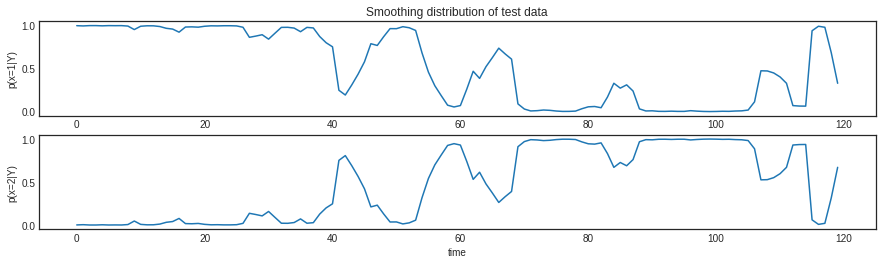

test smaple id: 25
acc = 0.8783783783783784


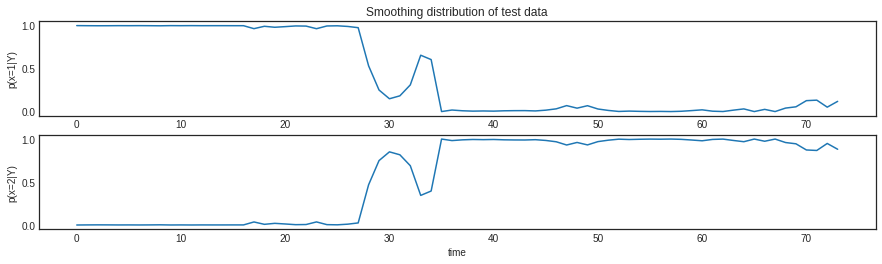

mean acc: 0.8219519117812669


In [ ]:
LOOCV_withoutF5()

##contextual data

In [ ]:
def ind_feature_probs_context(all_samples_with_c,c_data, K=K_ ) :
    max_series = c_data.max()
    eps_matrices = [np.zeros((int(i)+1,K), dtype=np.longdouble) for i in max_series[1:]]
    
    for k in range(K):
        all_with_target_k = all_samples_with_c.loc[all_samples_with_c['target']==k+1]
        num_target = len(all_with_target_k)
        
        for c in range(len(eps_matrices)):
            key = 'c' + str(c+1)
            value_counts = all_with_target_k[key].value_counts()
            
            for i in range(int(max_series[c+1])+1):
                if i in value_counts.keys():
                    eps_matrices[c][i][k] = value_counts[i]/num_target
                else:
                    eps_matrices[c][i][k] = 0.0
                    
    
    return eps_matrices

def context_emission(feature_probs, sample, K=K_ , C=C_):
    T = len(sample)
    E = np.ones((K,T), dtype=np.longdouble)
    for t in range(T):
        features = sample.iloc[t].tolist()[1:C_+1]
        for j in range(K):
            for ind , f_value in enumerate(features):
                if not pd.isnull(f_value):
                    if int(f_value) < feature_probs[ind].shape[0]:
                        E[j][t]*=feature_probs[ind][int(f_value)][j]
                    
    return E

In [ ]:
def LOOCV_context(C=C_):
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    acc_sum = 0.0
    excel_data = pd.read_excel('data/Contextual_data.xlsx',engine='openpyxl')
    c_data = pd.DataFrame(excel_data)
    for test in sample_ids:
        #preparing data
        test_ids = [test]
        train_samples = dict()
        test_samples = dict()
        for i in sample_ids:
            if i not in test_ids:
                train_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')
            else:
                test_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')

        train_samples_Xs = [train_samples[key]['target'].to_numpy() for key in train_samples.keys()]
        test_samples_Xs = [test_samples[key]['target'].to_numpy() for key in test_samples.keys()]

        all_train_samples = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)
        all_test_samples = pd.concat([test_samples[key] for key in test_samples.keys()], ignore_index=True,axis=0)

        M = comp_transitions(train_samples_Xs)
        pi = comp_pi(train_samples_Xs)
        if (pi == 0).any():
            pi = pi + 0.000000001
        feature_probs = ind_feature_probs(all_train_samples)
        test_E = emission(feature_probs,test_samples[str(test_ids[0])])
        
        for i in sample_ids:
            for c in range(C):
                if i not in test_ids:
                    train_samples[str(i)].insert(c+1 , 'c' + str(c+1) , c_data.loc[c_data['sample no.'] == i]['c' + str(c+1)].iloc[0])
                else:
                    test_samples[str(i)].insert(c+1 , 'c' + str(c+1) , c_data.loc[c_data['sample no.'] == i]['c' + str(c+1)].iloc[0])
        
        all_train_samples_with_C = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)
        all_test_samples_with_C = pd.concat([test_samples[key] for key in test_samples.keys()], ignore_index=True,axis=0)
        
        context_feature_probs = ind_feature_probs_context(all_train_samples_with_C , c_data)
        context_test_E = context_emission(context_feature_probs,test_samples[str(test_ids[0])],C=C)
        
        test_E = test_E * context_test_E
        if (test_E == 0).any():
            test_E = test_E + 0.000000001

        alpha , _ = alpha_recursion(pi, M, test_E)
        beta , _ = beta_recursion(pi, M, test_E)
        gamma = smoothing(alpha,beta)
        print(f'test smaple id: {test_ids[0]}')
        acc = ((gamma.argmax(axis = 0) + 1) == test_samples_Xs[0]).sum() / gamma.shape[1]
        print(f'acc = {acc}')
        acc_sum += acc
        plot_smoothing(gamma)


    print(f'mean acc: {acc_sum / len(sample_ids)}')

test smaple id: 1
acc = 0.9113924050632911


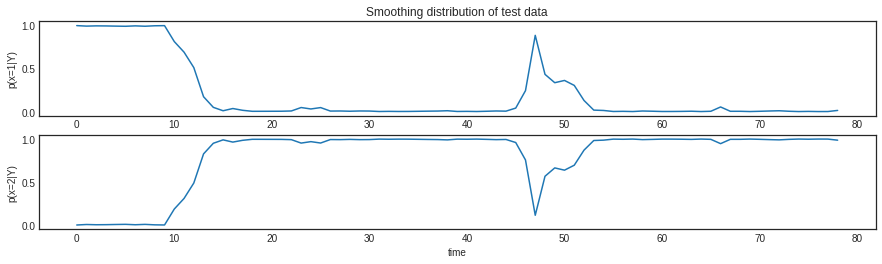

test smaple id: 2
acc = 0.9444444444444444


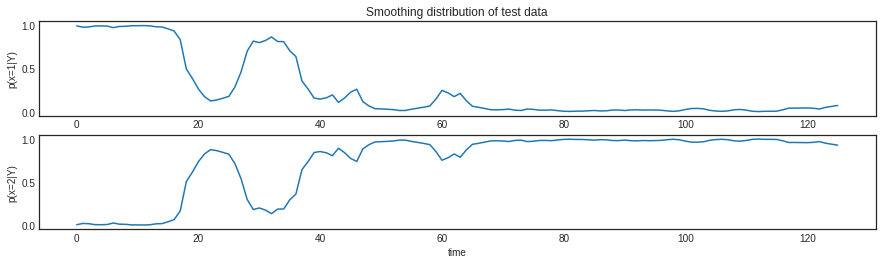

test smaple id: 3
acc = 0.5416666666666666


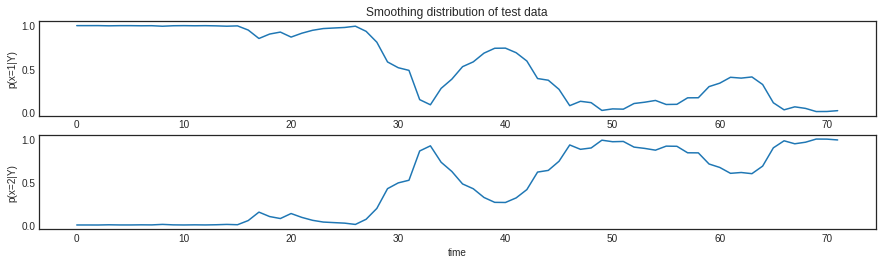

test smaple id: 4
acc = 0.8532110091743119


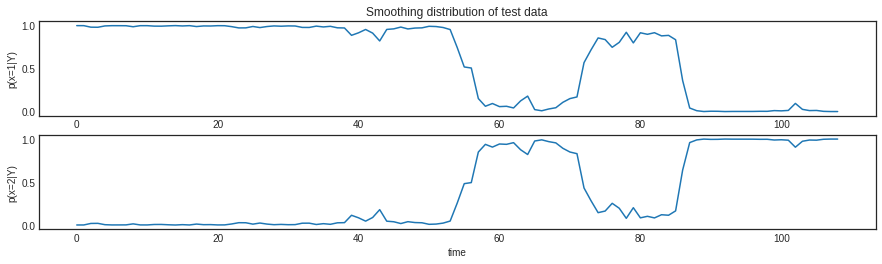

test smaple id: 5
acc = 0.9428571428571428


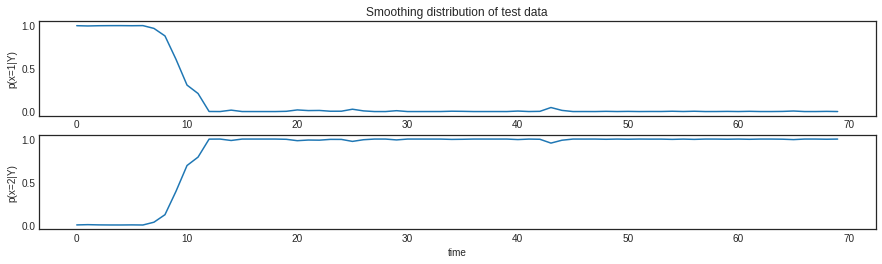

test smaple id: 6
acc = 0.968421052631579


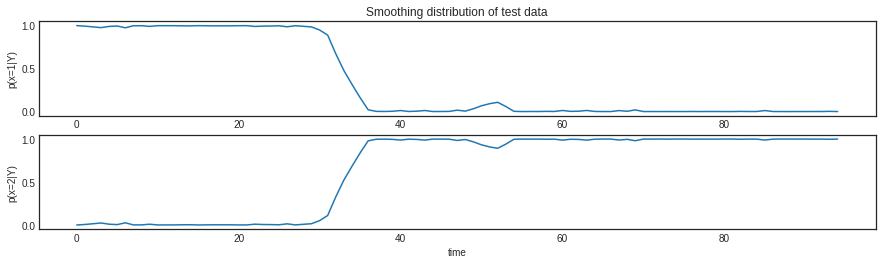

test smaple id: 7
acc = 0.8433734939759037


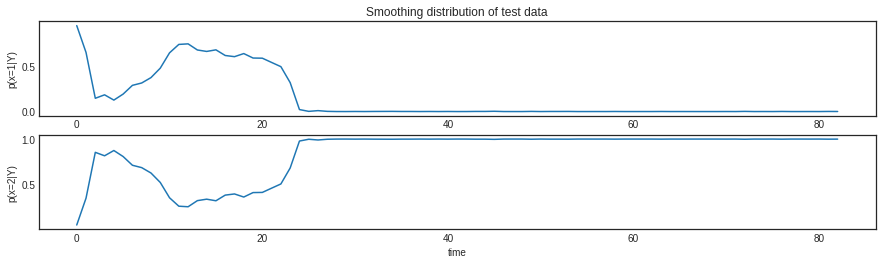

test smaple id: 8
acc = 1.0


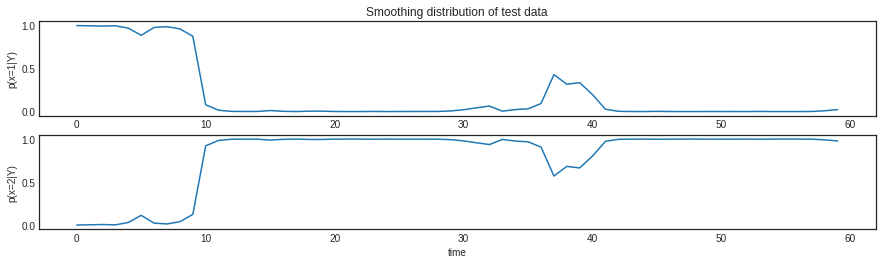

test smaple id: 11
acc = 0.9


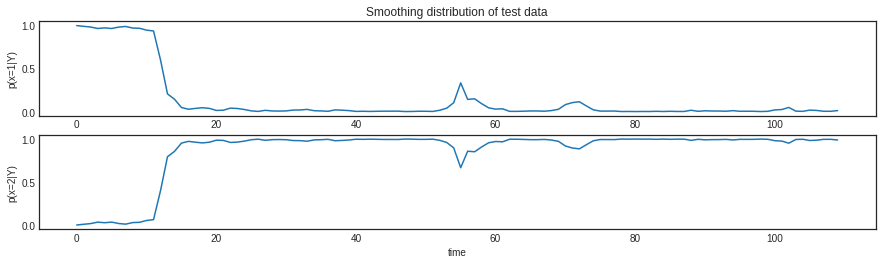

test smaple id: 12
acc = 0.9622641509433962


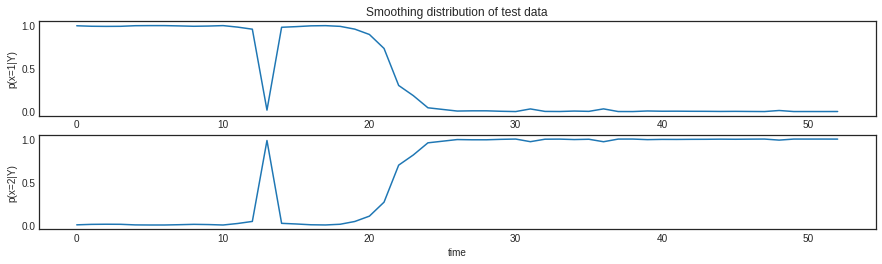

test smaple id: 13
acc = 0.9029126213592233


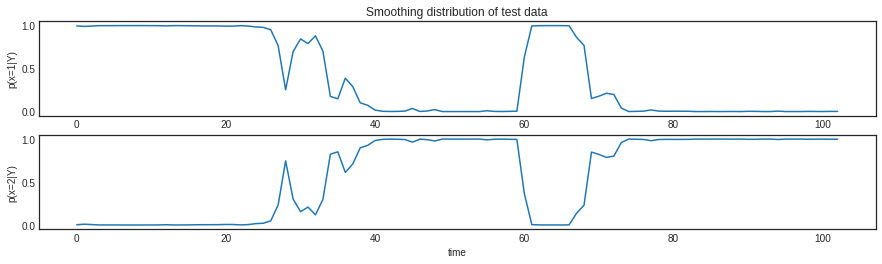

test smaple id: 14
acc = 0.8857142857142857


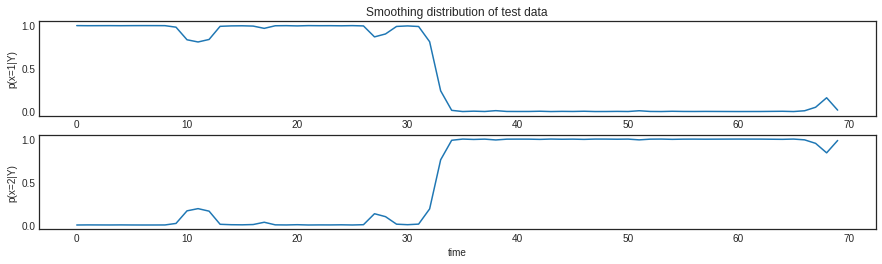

test smaple id: 15
acc = 0.9456521739130435


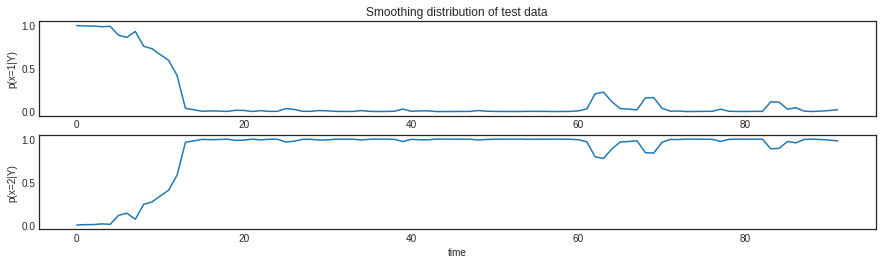

test smaple id: 16
acc = 0.3181818181818182


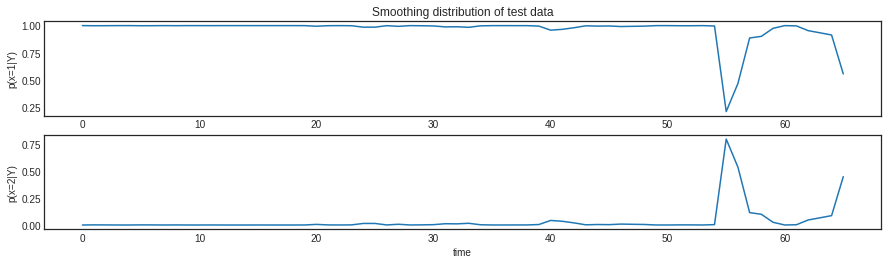

test smaple id: 18
acc = 0.7553956834532374


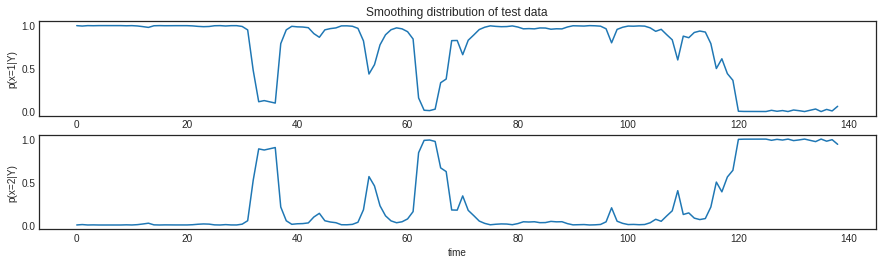

test smaple id: 19
acc = 0.8285714285714286


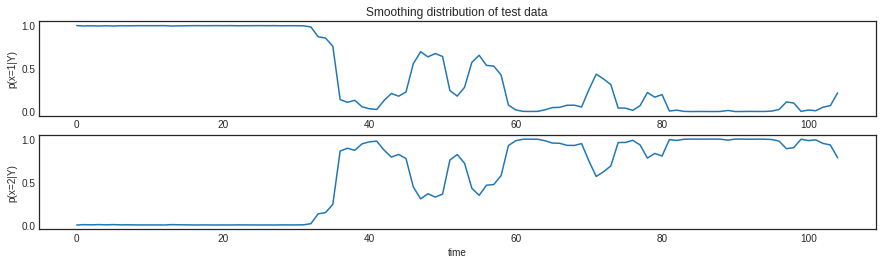

test smaple id: 20
acc = 0.9761904761904762


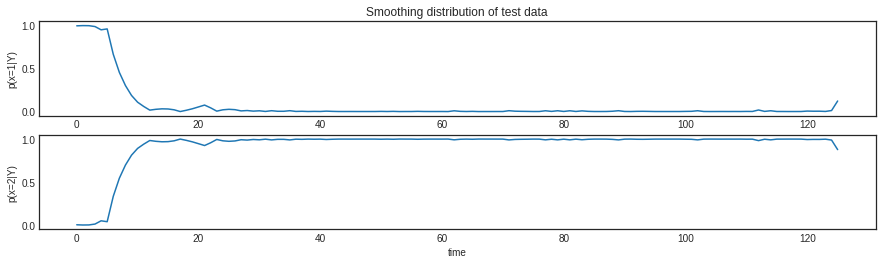

test smaple id: 21
acc = 0.31313131313131315


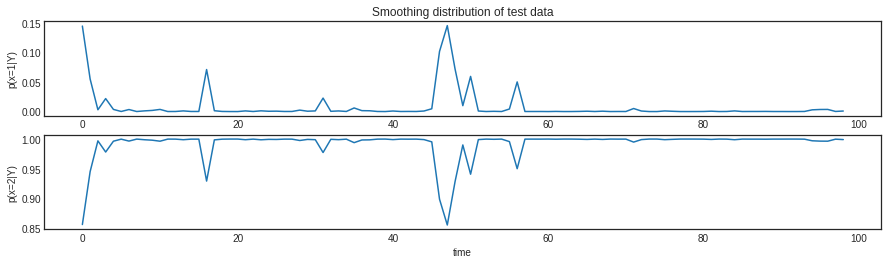

test smaple id: 23
acc = 0.21311475409836064


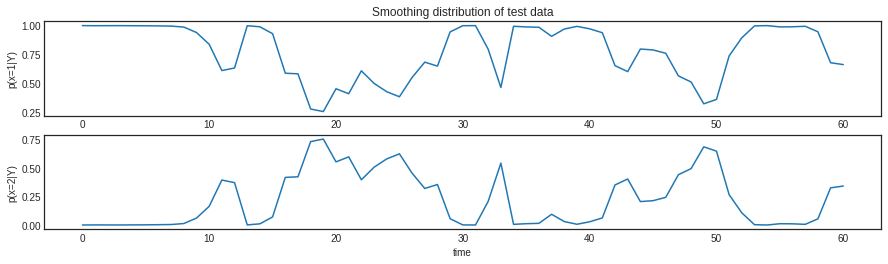

test smaple id: 24
acc = 0.6583333333333333


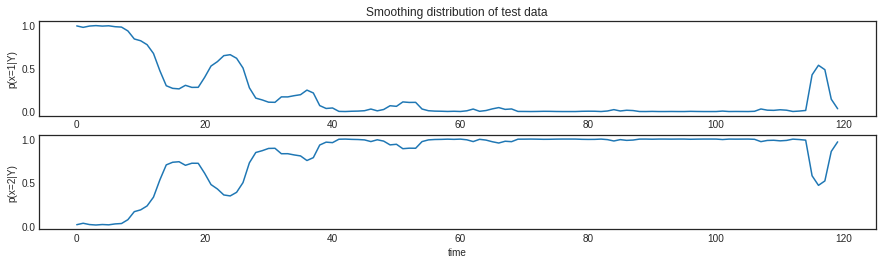

test smaple id: 25
acc = 0.8243243243243243


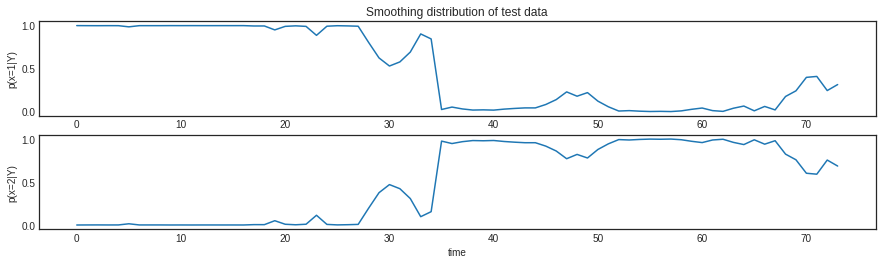

mean acc: 0.7851977418108371


In [ ]:
LOOCV_context()

## different combination of features

In [ ]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [ ]:
def LOOCV_featureComb():
    features_super_set = list(powerset(['f1' ,'f2' ,'f3' ,'f4' ,'f5' ]))
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    
    for features_subset in features_super_set:
        if (len(features_subset) > 0):
            acc_sum = 0.0
            columns = list(features_subset)
            columns.append('target')
            columns.insert(0 , 'Unnamed: 0')
            print(f'selected features: {features_subset}')
            rename_dict = dict()
            for i,f in enumerate(features_subset):
                rename_dict[f] = 'f' + str(i+1)
                
            for test in sample_ids:
                #preparing data
                test_ids = [test]
                train_samples = dict()
                test_samples = dict()
                    

                for i in sample_ids:
                    if i not in test_ids:
                        train_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')
                        train_samples[str(i)].fillna(0, inplace=True)
                        train_samples[str(i)] = train_samples[str(i)][columns]
                        train_samples[str(i)].rename(columns=rename_dict, inplace=True)
                        
                    else:
                        test_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')
                        test_samples[str(i)].fillna(0, inplace=True)
                        test_samples[str(i)] = test_samples[str(i)][columns]
                        test_samples[str(i)].rename(columns=rename_dict, inplace=True)
                        
                train_samples_Xs = [train_samples[key]['target'].to_numpy() for key in train_samples.keys()]
                test_samples_Xs = [test_samples[key]['target'].to_numpy() for key in test_samples.keys()]

                all_train_samples = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)
                all_test_samples = pd.concat([test_samples[key] for key in test_samples.keys()], ignore_index=True,axis=0)

                M = comp_transitions(train_samples_Xs)
                pi = comp_pi(train_samples_Xs)
                feature_probs = ind_feature_probs(all_train_samples)
                test_E = emission(feature_probs,test_samples[str(test_ids[0])])
                
                if (test_E == 0).any():
                    test_E = test_E + 0.000000001

                alpha , _ = alpha_recursion(pi, M, test_E)
                beta , _ = beta_recursion(pi, M, test_E)
                gamma = smoothing(alpha,beta)
                #print(f'test smaple id: {test_ids[0]}')
                acc = ((gamma.argmax(axis = 0) + 1) == test_samples_Xs[0]).sum() / gamma.shape[1]
                #print(f'acc = {acc}')
                acc_sum += acc
                #plot_smoothing(gamma)


            print(f'mean acc: {acc_sum / len(sample_ids)}')

In [ ]:
LOOCV_featureComb()

selected features: ('f1',)
mean acc: 0.7942043060495914
selected features: ('f2',)
mean acc: 0.5429574552989935
selected features: ('f3',)
mean acc: 0.6930229381886778
selected features: ('f4',)
mean acc: 0.7352412966923187
selected features: ('f5',)
mean acc: 0.8015573877256423
selected features: ('f1', 'f2')
mean acc: 0.7999379668459189
selected features: ('f1', 'f3')


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


mean acc: 0.8000031946180173
selected features: ('f1', 'f4')
mean acc: 0.7986072484736975
selected features: ('f1', 'f5')
mean acc: 0.8125749783294927
selected features: ('f2', 'f3')
mean acc: 0.6812947048109594
selected features: ('f2', 'f4')
mean acc: 0.7132707316715137
selected features: ('f2', 'f5')
mean acc: 0.6456130005543078
selected features: ('f3', 'f4')
mean acc: 0.6701274146053509
selected features: ('f3', 'f5')
mean acc: 0.7409457034104264
selected features: ('f4', 'f5')
mean acc: 0.7827939758582493
selected features: ('f1', 'f2', 'f3')
mean acc: 0.8067543929018812
selected features: ('f1', 'f2', 'f4')
mean acc: 0.8142513795982044
selected features: ('f1', 'f2', 'f5')
mean acc: 0.8188656239128491
selected features: ('f1', 'f3', 'f4')
mean acc: 0.8067073998822432
selected features: ('f1', 'f3', 'f5')
mean acc: 0.8211022236894766
selected features: ('f1', 'f4', 'f5')
mean acc: 0.8190733199470601
selected features: ('f2', 'f3', 'f4')
mean acc: 0.6771785111389862
selected featu

##TEST

In [ ]:
def train(features_keys):
    sample_ids = [1,2,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,23,24,25]
    columns = list(features_keys)
    columns.append('target')
    columns.insert(0 , 'Unnamed: 0')
    rename_dict = dict()
    
    for i,f in enumerate(features_keys):
        rename_dict[f] = 'f' + str(i+1)
        
    train_samples= dict()
    for i in sample_ids:     
        train_samples[str(i)] = pd.read_csv('data/samples/sample_'+str(i)+'.csv')
        train_samples[str(i)].fillna(0, inplace=True)
        train_samples[str(i)] = train_samples[str(i)][columns]
        train_samples[str(i)].rename(columns=rename_dict, inplace=True)


    train_samples_Xs = [train_samples[key]['target'].to_numpy() for key in train_samples.keys()]

    all_train_samples = pd.concat([train_samples[key] for key in train_samples.keys()], ignore_index=True,axis=0)

    M = comp_transitions(train_samples_Xs)
    pi = comp_pi(train_samples_Xs)
    feature_probs = ind_feature_probs(all_train_samples)
    return pi, M, feature_probs

In [ ]:
def TEST(test_ids):
    feature_combs = [('f1', 'f2', 'f3', 'f4', 'f5') ,('f1', 'f2', 'f4', 'f5') ,('f1', 'f2', 'f3', 'f5')]
    for j , feature_subset in enumerate(feature_combs):
        print(f'model {j+1} selected features: {feature_subset}')
        pi , M, feature_probs = train(feature_subset)
        
        columns = list(feature_subset)
        columns.insert(0 , 'Unnamed: 0')
        rename_dict = dict()
        for i,f in enumerate(feature_subset):
            rename_dict[f] = 'f' + str(i+1)
        for i in test_ids:
            test_sample = pd.read_csv('data/samples/test_'+str(i)+'.csv')
            test_sample.fillna(0, inplace=True)
            test_sample = test_sample[columns]
            test_sample.rename(columns=rename_dict, inplace=True)
            test_E = emission(feature_probs,test_sample , test=True)

            if (test_E == 0).any():
                test_E = test_E + 0.000000001

            alpha , _ = alpha_recursion(pi, M, test_E)
            beta , _ = beta_recursion(pi, M, test_E)
            gamma = smoothing(alpha,beta)
            preds = gamma.argmax(axis = 0) + 1
            preds = pd.DataFrame({'preds':preds})
            preds.to_csv(f'output_{str(i)}_model{j+1}.csv')

In [ ]:
#test_ids is a list of integer which contains ids (test_id.csv) for test files
test_ids = [1,2]
TEST(test_ids)